In [ ]:
!sudo apt update
!sudo apt-get update
!pip install --upgrade --force-reinstall pandas scipy numpy matplotlib
!pip install cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

!sudo apt-get install texlive-latex-recommended
!sudo apt install texlive-latex-base texlive-latex-extra texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import os
os.kill(os.getpid(), 9)

In [ ]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/lib/python3.10/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.8/nvvm/libdevice
find: ‘/proc/57/task/57/net’: Invalid argument
find: ‘/proc/57/net’: Invalid argument
/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so
^C


In [ ]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-11.8/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so"

# Imports

--2023-06-23 19:01:20--  https://dl.freefontsfamily.com/download/Helvetica-Font
Resolving dl.freefontsfamily.com (dl.freefontsfamily.com)... 37.49.229.234
Connecting to dl.freefontsfamily.com (dl.freefontsfamily.com)|37.49.229.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 744473 (727K) [application/zip]
Saving to: ‘Helvetica-Font’

Helvetica-Font      100%[===================>] 727.02K  4.21MB/s    in 0.2s    

2023-06-23 19:01:21 (4.21 MB/s) - ‘Helvetica-Font’ saved [744473/744473]

rm: cannot remove 'LICENSE_OFL.txt': No such file or directory
rm: cannot remove 'README': No such file or directory
rm: cannot remove '*.otf': No such file or directory
Archive:  Helvetica-Font
  inflating: Helvetica.ttf           
  inflating: Helvetica-Oblique.ttf   
  inflating: helvetica-compressed-5871d14b6903a.otf  
  inflating: helvetica-rounded-bold-5871d05ead8de.otf  
  inflating: Helvetica-Bold.ttf      
  inflating: Helvetica-BoldOblique.ttf  
  inflating: helvet

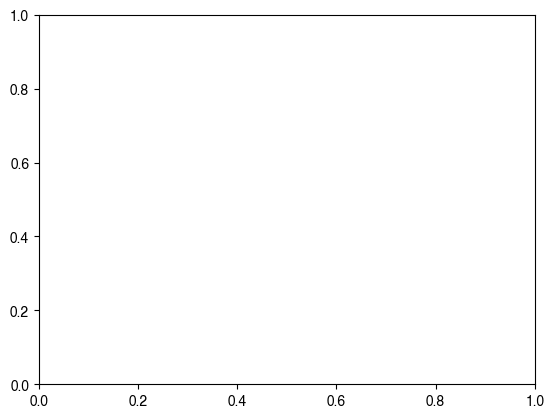

In [1]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy
import shapely as shp
from shapely import Point
import psutil
import time
import sys
import numpy as np
import networkx as nx
import pandas as pd
import scipy as sp
import scipy.fftpack as fftpack
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
from sklearn import manifold
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from matplotlib import rc
%matplotlib inline

np.set_printoptions(linewidth=250)


# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}\let\vec\mathbf')


plt.rcParams['savefig.bbox'] = 'tight'

# !sudo apt-get install texlive-latex-recommended
# !sudo apt install texlive-latex-base texlive-latex-extra texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

font_dir = '/usr/local/lib/python' + str(sys.version_info[0]) + '.' + str(sys.version_info[1]) + '/dist-packages/matplotlib/mpl-data/fonts/ttf/'


if 'Helvetica.ttf' not in os.listdir(font_dir):
  !wget "https://dl.freefontsfamily.com/download/Helvetica-Font"
  !rm LICENSE_OFL.txt README *.otf
  !unzip Helvetica-Font
  !mv Helvetica.ttf $font_dir

import matplotlib.font_manager as fm
# fm.FontProperties(fname='/content/gdrive/MyDrive/Helvetica.ttf', size= 24)
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
# fm.fontManager.ttflist += fm.createFontList(['/content/gdrive/MyDrive/Helvetica.ttf'])
# mpl.rc('font', family='Helvetica')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
font = {'fontname':'Helvetica'}

# Mount Drive

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# Set this as the directory in which to save figures
base_dir = '/content/gdrive/My Drive/Amazon Project/'
if not os.path.isdir(base_dir + 'Figures/'):
  os.mkdir(base_dir + 'Figures/')
fig_dir = base_dir + 'Figures/Manifolds/'
if not os.path.isdir(fig_dir):
  os.mkdir(fig_dir)

data_dir = base_dir + 'Data/'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

os.chdir(base_dir)

Mounted at /content/gdrive


# Helper Functions

In [3]:
def haversine(lon1, lat1, lon2, lat2, r=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
#     lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return c * r

def haversine_np(lon1, lat1, lon2, lat2, r=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return c * r

def nearest_neighbors(lat,lon,latlon_icos, r=6371, num_neighbors=4, radius=None):
    """
    Find nearest neighbors (using geodesic distance) of given point

    if radius is None, find closest num_neighbors neighbors
    else, find list of neighbors within radius
    """
    lats = np.zeros((len(latlon_icos),)) + lat
    lons = np.zeros((len(latlon_icos),)) + lon
    distances = haversine_np(lons,lats,latlon_icos[:,1],latlon_icos[:,0], r)

    if radius is not None:
        neighbors = []
        for i in range(len(latlon_icos)):
            lat_icos, lon_icos = latlon_icos[i]
            if distances[i] <= radius:
                neighbors.append((i,distances[i]))
        return neighbors
    else:
        neighbors = [(i,distances[i]) for i in range(len(distances))]

        neighbors.sort(key = lambda k: k[1])
        return neighbors[:num_neighbors]

def interpolate_point(lat,lon,latlon_icos,data, r=6371, num_neighbors=4, radius=None):
    """
    Interpolate point using convolution of nearest geodesic neighbors - found either via
    fixed 'num_neighbors' scheme or via all points within 'radius' geodesic distance of input
    """
    neighbors = nearest_neighbors(lat,lon,latlon_icos, r=r,
                                  num_neighbors=num_neighbors, radius=radius)
    return np.sum([(1/dist)*data[i] for (i,dist) in neighbors])/np.sum([(1/dist) for (i,dist) in neighbors])

def interpolate_points(lats,lons,latlon_icos,data, r=6371, num_neighbors=4, radius=None, desc=''):
    """
    Interpolate a sequence of latitude-longitude points given by 'lats' and 'lons' (equal size 1D array)
    using convolution of nearest geodesic neighbors - found either via
    fixed 'num_neighbors' scheme or via all points within 'radius' geodesic distance of input
    """
    results = np.zeros((len(lats),))
    for i in trange(len(lats), desc=desc, leave=False):
        lat, lon = lats[i], lons[i]
        results[i] = interpolate_point(lat,lon,latlon_icos,data, r=r,
                                       num_neighbors=num_neighbors,
                                       radius=radius)
    return results

def replace_points_near_poles(ilat, ilon, idat, latlon_icos, data,
                              threshold=15, num_neighbors=4, radius=None):
    """
    To fix artifacting near poles, manually interpolate with nearest neighbors

    ilon, ilat is meshgrid over globe
    idat is associated interpolation of data
    data is list of some value for each node in latlon_icos

    90-threshold and -90+threshold (in degrees) are latidues to replace

    """
    close_to_poles = np.concatenate((np.where(abs(ilat[:,0]-90) < threshold)[0],
                                     np.where(abs(ilat[:,0]+90) < threshold)[0]))

    lons = [lon for i in range(len(close_to_poles)) for lon in ilon[0,:]]
    lats = [ilat[lat,0] for lat in close_to_poles for i in range(len(ilon[0,:]))]

    results_close_to_poles = interpolate_points(lats,lons,latlon_icos,data,
                                                num_neighbors=num_neighbors,
                                                radius=radius,
                                                desc = 'Replacing Poles')

    nj = len(ilon[0,:])
    for i in range(len(close_to_poles)):
        lat_ind = close_to_poles[i]
        for j in range(nj):
            idat[lat_ind,j] = results_close_to_poles[nj*i + j]

    return idat

def replace_points_near_dateline(ilat, ilon, idat, latlon_icos, data,
                                 threshold=5, num_neighbors=4, radius=None):
    """
    To fix artifacting near dateline, manually interpolate with longitude periodicity from 0 to 360

    ilon, ilat is meshgrid over globe
    idat is associated interpolation of data
    data is list of some value for each node in latlon_icos

    +/- threshold (in degrees) are longitudes to replace

    """
    close_to_dateline = np.concatenate((np.where(abs(ilon[0,:]) < threshold)[0],
                                        np.where(abs(ilon[0,:]-360) < threshold)[0]))

    lons = [ilon[0,lon] for lon in close_to_dateline for i in range(len(ilat[:,0]))]
    lats = [lat for i in range(len(close_to_dateline)) for lat in ilat[:,0]]

    results_close_to_dateline = interpolate_points(lats,lons,latlon_icos,data,
                                                   num_neighbors=num_neighbors,
                                                   radius=radius,
                                                   desc = 'Replacing Dateline')

    nj = len(ilat[:,0])
    for i in range(len(close_to_dateline)):
        lon_ind = close_to_dateline[i]
        for j in range(nj):
            idat[j,lon_ind] = results_close_to_dateline[nj*i + j]

    return idat

def replace_points_where_nan(ilat, ilon, idat, latlon_icos, data, num_neighbors=4, radius=None):
    """
    Use custom interpolation (using nearest geodesic neighbors) for points that are np.nan

    Can be used to simply fill in values mixed in scipy griddata interpolation due to longitude
    or latitude outside input icosahedral range.

    However, it is not guaranteed that this will fix the seam at the dateline - values with longtidue
    slightly larger than 0 may not smoothly vary since usually the scipy griddata interpolation misses
    data just to the *WEST* of the dateline. Therefore even if those missing values are replaced, there
    may be a seam across the dateline (longutude 0 degrees). TO FIX THIS, SIMPLY USE THE
    replace_points_near_dateline FUNCTION TO INTERPOLATE DATA TO THE WEST *AND* EAST OF THE DATELINE.
    """
    where = np.where(np.isnan(idat))

    lats = ilat[where[0],0]
    lons = ilon[0,where[1]]

    results_where_nans = interpolate_points(lats,lons,latlon_icos,data,
                                            num_neighbors=num_neighbors,
                                            radius=radius,
                                            desc = 'Replacing NaNs')

    for i in range(len(lats)):
        lat_ind = where[0][i]
        lon_ind = where[1][i]

        idat[lat_ind,lon_ind] = results_where_nans[i]

    return idat

def replace_points_in_shapefile(shape_filename, ilat, ilon, idat, fill_value=np.nan, inside=True):
    """
    This function can read a shapefile and fill values from the interpolated grid with 'fill_value'
    when they fall inside of the shapefile. This is useful since the interpolation of scatter data will
    fill in all values - even those that are intentionally left blank.

    OPTIONALLY: Specify inside=False to reverse which points are excluded - here the points *OUTSIDE*
    the shapefile are filled with 'fill_value'.

    TODO: Check if shapefiles with multiple polygons will break function - it was only tested with a
    contiguous-polygon shapefile.
    """
    from shapely.ops import unary_union
    import shapely.vectorized

    reader = shpreader.Reader(shape_filename)

    shape_geom = unary_union(list(reader.geometries()))

    shape_mask = shapely.vectorized.contains(shape_geom, ilon, ilat)
    shape_mask = np.logical_or(shape_mask,
                   shapely.vectorized.contains(shape_geom, ilon-360, ilat))

    idat[np.where(shape_mask == inside)] = fill_value

    return idat

def interpolate_scatter_data(latlon_icos, data, method='linear',
                             threshold_dateline=5, threshold_poles=15,
                             replace_nans = True,
                             num_neighbors=4, radius=None,
                             extent=[0, 360, -90, 90], filler=0,
                             num_interp_pts=200, shape_filename=None,
                             fill_value=np.nan):
    """
    This function takes scatter data as input - with (presumably icosahedral) coordinates 'latlon_icos',
    which is an (N,2)-size list of latitude-longitude pairs, and length-N 'data' specifying the pertinent
    qualitative information for each latitude-longitude pair.

    The output of the function is interpolated grid data intended for use in a contourf plot, consiting of
    'ilon' longitudinal grid - (num_interp_pts,num_interp_pts)
    'ilat' latitudinal grid - (num_interp_pts,num_interp_pts)
    'idat' grid data - (num_interp_pts,num_interp_pts)

    The basic interpolation is performed with scipy.interpolate.griddata, which currently has the flaw of
    not extrapolating under a method='linear' interpolation scheme. It also currently has no way to make
    use of the periodicity over the dateline (longitude = 0 degrees).

    In order to fix the missing points left by scipy.interpolate.griddata, three methods were developed:
    1) Replace points within some degree longitude of the dateline
    2) Replace points within some degree of the poles
    3) Replace all points filled with np.nan
    All three methods utilize a nearest-neighbor convolution, where points with low geodesic distance to
    the grid point are put under a weighted average to fill the grid data. See the function
    interpolate_points for details.

    Lastly, optionally fill values that fall inside (or outside) a supplied shapefile with given 'fill_value'.
    """
    from scipy.interpolate import griddata

    ilon = np.linspace(extent[0]-filler, extent[1]+filler, num_interp_pts)
    ilat = np.linspace(extent[2]-filler, extent[3]+filler, num_interp_pts)
    ilon, ilat = np.meshgrid(ilon, ilat)
    idat = griddata((latlon_icos[:,1], latlon_icos[:,0]), data,
                    (ilon, ilat), method=method)

    if threshold_dateline > 0:
        idat = replace_points_near_dateline(ilat, ilon, idat, latlon_icos,
                                            data, threshold=threshold_dateline,
                                            num_neighbors=num_neighbors,
                                            radius=radius)
    if threshold_poles > 0:
        idat = replace_points_near_poles(ilat, ilon, idat, latlon_icos,
                                         data, threshold=threshold_poles,
                                         num_neighbors=num_neighbors,
                                         radius=radius)
    if replace_nans:
        idat = replace_points_where_nan(ilat, ilon, idat, latlon_icos, data,
                                        num_neighbors=num_neighbors,
                                        radius=radius)

    if shape_filename is not None:
        idat = replace_points_in_shapefile(shape_filename, ilat, ilon,
                                           idat, fill_value=fill_value)

    return ilat, ilon, idat

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    try:
        # mpl.cm.unregister_cmap(name)
        mpl.colormaps.unregister(name)
    except:
        pass
    # plt.register_cmap(cmap=newcmap)
    mpl.colormaps.register(cmap=newcmap)

    return newcmap

def yy_to_yyyy(yy):
    """
    Convert string of year in yy format to string in yyyy format
    """
    yy_int = int(yy)
    if yy_int < 10:
        return '200' + str(yy_int)
    elif yy_int < 48:
        return '20' + str(yy_int)
    else:
        return '19' + str(yy_int)


def start_year_to_date_range(start_year,year_interval=25):
    """
    Convert string of start year in yy format to date range string in yyyy-yyyy format
    """
    start = yy_to_yyyy(start_year)
    end = str(int(start) + year_interval)
    return start + '-' + end

def match_nodes(dates,finallons_dict,finallats_dict):
    f = gzip.open(data_dir + '/G/'+dates[0]+'.data','rb')
    G = pkl.load(f)
    f.close()
    N = G.number_of_nodes()

    node_matches = np.zeros((N,len(dates)))
    for node in G.nodes():
        node_matches[node,0] = node

    for i in trange(1,len(dates),desc='Matching'):
        for j in range(N):
            node_matches[j,i] = np.where(np.logical_and(finallons_dict[dates[i]] == finallons_dict[dates[0]][j],
                                   finallats_dict[dates[i]] == finallats_dict[dates[0]][j]))[0][0]

    return node_matches.astype(int)

def get_trend(trend_dict,dates,finallons_dict,finallats_dict,normalize=False):
    f = gzip.open(data_dir + '/G/'+dates[0]+'.data','rb')
    G = pkl.load(f)
    f.close()
    nodes = list(G.nodes())

    node_matches = match_nodes(dates,finallons_dict,finallats_dict)

    trend = np.zeros((len(nodes),1))

    for node in nodes:
#         slope, _ = np.polyfit(list(range(48)), [trend_dict[date][node,1] for date in dates], 1)
        slope, _ = np.polyfit(list(range(48)), [trend_dict[dates[i]][node_matches[node,i]] for i in range(len(dates))], 1)
        trend[node] = slope

    if normalize:
#         return np.interp(trend, (trend.min(), trend.max()), (-1, +1))
        return trend/abs(min(trend))
    else:
        return trend

# Manifolds

## Directed

In [4]:
months = 300
offset = 365.25
k = 50

edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',k={:}'.format(k)+'/'
graph_dir = data_dir + 'G-months='+str(months)+',offset='+str(offset)+',k={:}'.format(k)+'/'

dir_end = '-months={:},offset={:},k={:}/'.format(months,offset,k)

total_networks = len(os.listdir(edge_dir))

num_nodes = 10242

with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'rb') as file:
  year_intervals = pkl.load(file)

with gzip.open(data_dir + 'date_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'rb') as file:
  date_intervals = pkl.load(file)

dates = [year_intervals[i][0] + '-' + year_intervals[i][1] for i in range(len(year_intervals))]

with gzip.open(data_dir + 'icosahedral_grid.data', 'rb') as file:
    latlon_icos = np.array(pkl.load(file))

recompute = False

if recompute:
  amazon_nodes = []

  reader = shpreader.Reader(base_dir+'Amazon Biome/amazonia.shp')
  amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())

  for i in range(num_nodes):
    if amazon._geoms[0].contains(Point(latlon_icos[i,1]-360,latlon_icos[i,0])):
      amazon_nodes.append(i)

  with gzip.open(data_dir + 'amazon_nodes_new_networks.data', 'wb') as file:
    pkl.dump(amazon_nodes, file)
else:
  with gzip.open(data_dir + 'amazon_nodes_new_networks.data', 'rb') as file:
    amazon_nodes = pkl.load(file)

In [ ]:
manifold_dir = data_dir + 'Manifolds/'
if not os.path.isdir(manifold_dir):
  os.mkdir(manifold_dir)

recompute = False
if recompute:
  manifold_dict = {}
  for date in tqdm(dates):
    with gzip.open(graph_dir + date + '.data', 'rb') as file:
      G = pkl.load(file)
    manifold_dict[date] = manifold.spectral_embedding(nx.to_numpy_array(G),n_components=4,drop_first=True)

  with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'wb') as file:
    pkl.dump(manifold_dict, file)
else:
  with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'rb') as file:
    manifold_dict = pkl.load(file)

In [5]:
manifold_dir = data_dir + 'Manifolds/'
if not os.path.isdir(manifold_dir):
  os.mkdir(manifold_dir)

ks = [50, 100, 250, 500, 1000]

manifold_dict = {}

recompute = False

for k in ks:
  dir_end = '-months={:},offset={:},k={:}/'.format(months,offset,k)
  graph_dir = data_dir + 'G' + dir_end

  if recompute:
    manifold_dict = {}
    for date in tqdm(dates, desc=f'k={k}'):
      with gzip.open(graph_dir + date + '.data', 'rb') as file:
        G = pkl.load(file)
      manifold_dict[date] = manifold.spectral_embedding(nx.to_numpy_array(G),n_components=4,drop_first=True)

    with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'wb') as file:
      pkl.dump(manifold_dict, file)
  else:
    with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'rb') as file:
      manifold_dict[k] = pkl.load(file)


densities = [0.005, 0.01, 0.025, 0.05, 0.1]

for density in densities:
  dir_end = '-months={:},offset={:},density={:}/'.format(months,offset,density)
  graph_dir = data_dir + 'G' + dir_end

  if recompute:
    manifold_dict = {}
    for date in tqdm(dates, desc=f'density={density}'):
      with gzip.open(graph_dir + date + '.data', 'rb') as file:
        G = pkl.load(file)
      manifold_dict[date] = manifold.spectral_embedding(nx.to_numpy_array(G),n_components=4,drop_first=True)

    with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'wb') as file:
      pkl.dump(manifold_dict, file)
  else:
    with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'rb') as file:
      manifold_dict[density] = pkl.load(file)

In [ ]:
np.sqrt(np.sum(manifold_dict[50][dates[0]]**2,1))[amazon_nodes]

array([0.00229919, 0.00249442, 0.0025397 , 0.00249069, 0.00256283, 0.00254539, 0.00256258, 0.00251642, 0.00257282, 0.0025531 , 0.00256516, 0.00257392, 0.00251683, 0.00258143, 0.00254495, 0.00256862, 0.00253795, 0.00257985, 0.00258624, 0.00255752,
       0.00250046, 0.00257336, 0.00258765, 0.00256509, 0.00253994, 0.00258376, 0.0025831 , 0.00255217, 0.00259438, 0.00256979, 0.00250131, 0.00257166, 0.00259755, 0.00255732, 0.00253466, 0.00261522, 0.00258252, 0.002555  , 0.00255364, 0.00262066,
       0.00256941, 0.00248528, 0.00264616, 0.00261226, 0.00256147, 0.00253662, 0.00254485, 0.00266623, 0.00259291, 0.00239197, 0.00255964, 0.00267212, 0.00264321, 0.00256943, 0.00246356, 0.00270827, 0.00263395, 0.00230369, 0.00255866, 0.00251245,
       0.00269657, 0.00268977, 0.0026124 , 0.00237856, 0.00254142, 0.00273396, 0.00266861, 0.00258367, 0.00244096, 0.00273358, 0.00272441, 0.00265599, 0.00231914, 0.00255903, 0.00249159, 0.00270242, 0.00262095, 0.00240166, 0.00251916, 0.00275851,
       0.002

In [ ]:
from scipy.spatial.distance import cdist

In [6]:
densities = [0.005, 0.01, 0.025, 0.05, 0.1]
ks = [50, 100, 250, 500, 1000]

inds = []
for i in amazon_nodes:
  inds += [(i,j) for j in np.setdiff1d(amazon_nodes,i)]
inds = np.array(inds)

recompute = False

if recompute:
  pairwise_dist_dict = {}

  for density in densities:
    pairwise_dist_dict[density] = [cdist(manifold_dict[density][date][:,:3],manifold_dict[density][date][:,:3])[inds[:,0],inds[:,1]] for date in tqdm(dates, leave=False, desc=f'density={density}')]

  for k in ks:
    pairwise_dist_dict[k] = [cdist(manifold_dict[k][date][:,:3],manifold_dict[k][date][:,:3])[inds[:,0],inds[:,1]] for date in tqdm(dates, leave=False, desc=f'k={k}')]

  with gzip.open(manifold_dir + 'pairwise_dist_dict.data', 'wb') as file:
    pkl.dump(pairwise_dist_dict, file)
else:
  with gzip.open(manifold_dir + 'pairwise_dist_dict.data', 'rb') as file:
    pairwise_dist_dict = pkl.load(file)

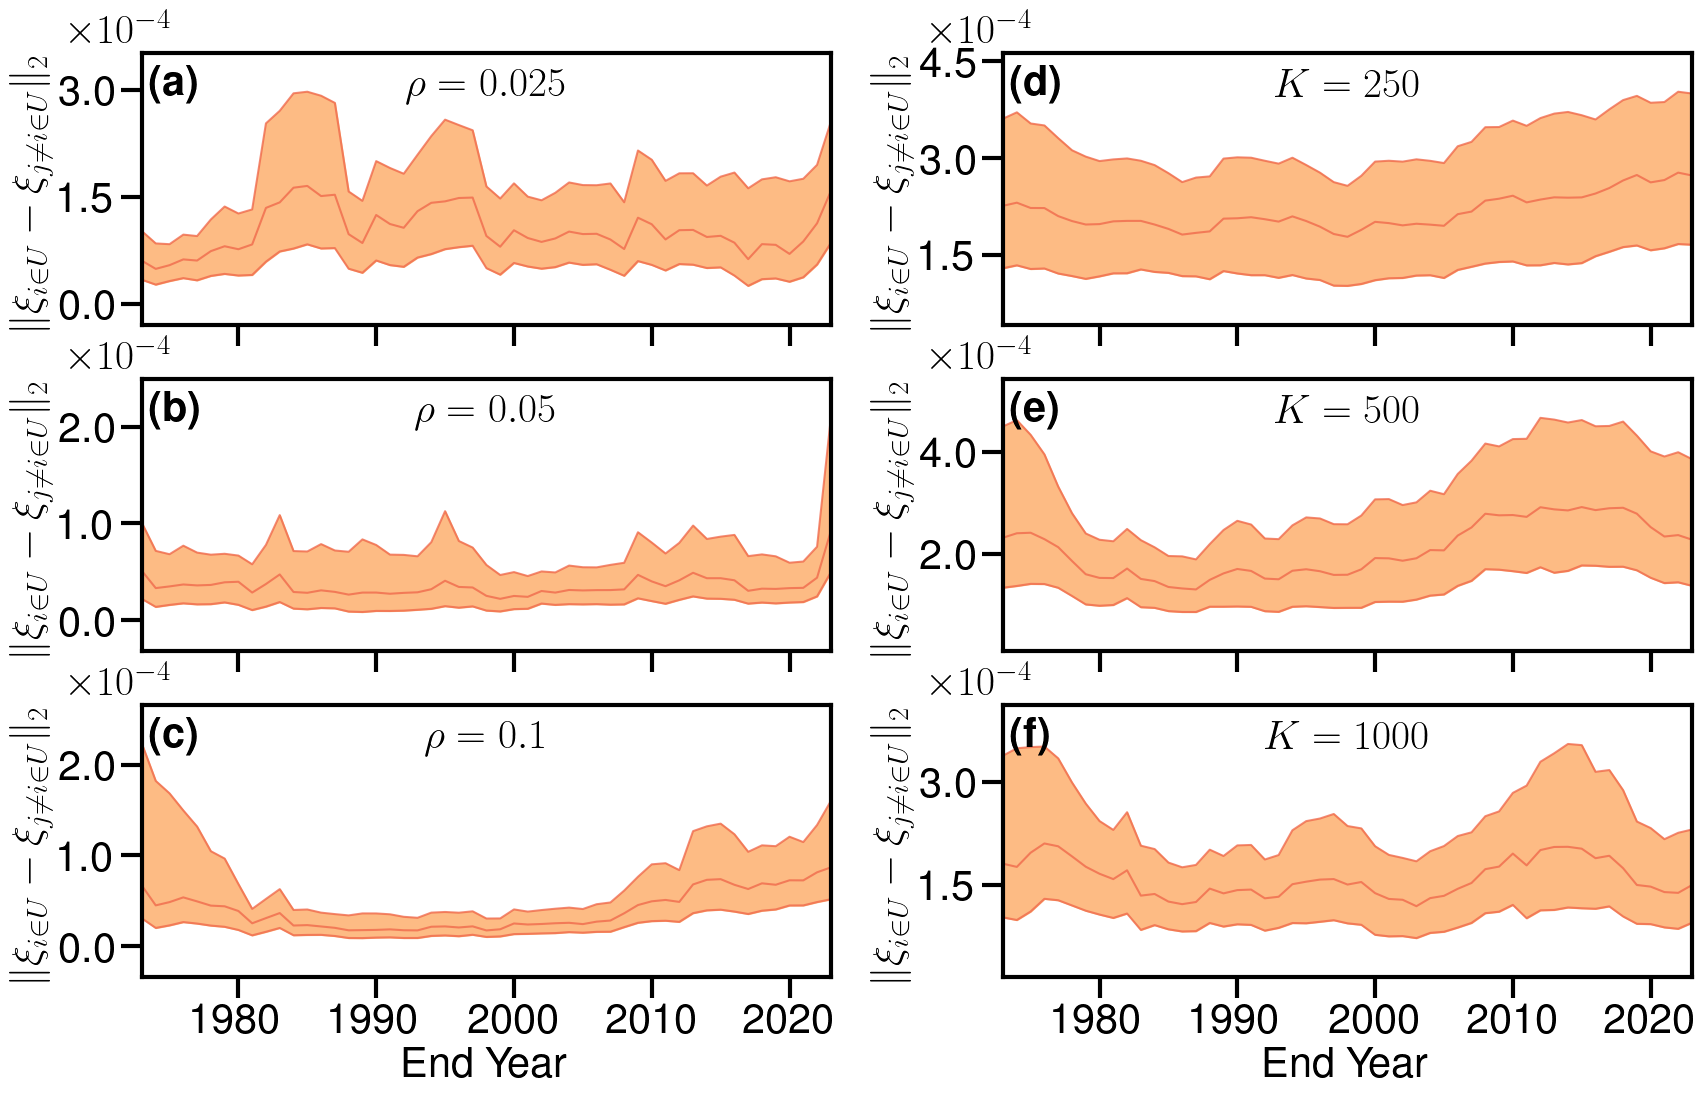

In [10]:
ks = [250, 500, 1000]
densities = [0.025, 0.05, 0.1]


from matplotlib.ticker import ScalarFormatter

class MagnitudeFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

def mid_and_bounds(data,p_val,mid_function=np.median):
  low, upp, mid = [], [], []
  for i in range(len(data)):
    low.append(np.percentile(data[i], p_val))
    upp.append(np.percentile(data[i], 100-p_val))
    mid.append(mid_function(data[i]))

  return low, upp, mid

fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

p_val = 25
alpha = 1
alpha_bounds = 0.75
color_bounds = '#fee8c8'
color = '#fdbb84'
color_mid = '#ef6548'
ms = 7.5
lw = 2
legendsize = 18

xy_annotate = (0.01, 0.85)

fig, axs = plt.subplots(max(len(ks),len(densities)), 2, sharex=True, sharey=False, figsize=(20,4*max(len(ks),len(densities))))

min_value = 0
max_value = 0

for i in range(len(ks)+len(densities)):

  if i < len(densities):
    # manifold_dist = [cdist(manifold_dict[densities[i]][date][:,:3],manifold_dict[densities[i]][date][:,:3])[inds[:,0],inds[:,1]] for date in dates]
    manifold_dist = pairwise_dist_dict[densities[i]]
    title = r'$\rho=' + str(densities[i]) + r'$'
    ax = axs[i,0]

    if i == len(densities) - 1:
      ax.set_xlabel('End Year', fontsize=fontsize)
      ax.set_xticklabels(xticklabels, fontsize=fontsize)

    #   ax.tick_params(bottom=True, top=False, left=True, right=False)
    # elif i == 0:
    #   # handles, labels = ax.get_legend_handles_labels()

    #   # ax.legend(handles, labels, loc='upper right',prop={'size': legendsize})
    #   ax.tick_params(bottom=False, top=False, left=True, right=False)
    # else:
    #   ax.tick_params(bottom=False, top=False, left=True, right=False)
  else:
    # manifold_dist = [cdist(manifold_dict[ks[i-len(densities)]][date][:,:3],manifold_dict[ks[i-len(densities)]][date][:,:3])[inds[:,0],inds[:,1]] for date in dates]
    manifold_dist = pairwise_dist_dict[ks[i-len(densities)]]
    title = r'$K=' + str(ks[i-len(densities)]) + r'$'
    ax = axs[i-len(densities),1]

    if i == len(densities) + len(ks) - 1:
      ax.set_xlabel('End Year', fontsize=fontsize)
      ax.set_xticklabels(xticklabels, fontsize=fontsize)

    #   ax.tick_params(bottom=True, top=False, left=True, right=False)
    # elif i == len(densities):
    #   # handles, labels = ax.get_legend_handles_labels()

    #   # ax.legend(handles, labels, loc='upper right',prop={'size': legendsize})
    #   ax.tick_params(bottom=False, top=False, left=True, right=False)
    # else:
    #   ax.tick_params(bottom=False, top=False, left=True, right=False)

  # low, upp, mid = mid_and_bounds(manifold_dist, 5)

  # ax.plot(np.arange(len(dates)),mid,color,alpha=alpha_bounds,zorder=2)
  # ax.plot(np.arange(len(dates)),low,'-',c=color,alpha=alpha_bounds,zorder=2)
  # ax.plot(np.arange(len(dates)),upp,'-',c=color,alpha=alpha_bounds,zorder=2)
  # ax.fill_between(np.arange(len(dates)),low, upp, color=color_bounds,
  #                 alpha=alpha,zorder=1)

  low, upp, mid = mid_and_bounds(manifold_dist, p_val)

  ax.plot(np.arange(len(dates)),mid,color_mid,alpha=alpha_bounds,zorder=2)
  ax.plot(np.arange(len(dates)),low,'-',c=color_mid,alpha=alpha_bounds,zorder=2)
  ax.plot(np.arange(len(dates)),upp,'-',c=color_mid,alpha=alpha_bounds,zorder=2)
  ax.fill_between(np.arange(len(dates)),low, upp, color=color,
                  alpha=alpha,zorder=1)

  min_value = np.min(low)
  max_value = np.max(upp)


  ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, xycoords='axes fraction', fontsize=fontsize)

  xticks = np.arange(7,len(dates),10)
  xticklabels = [dates[i].split('-')[1] for i in xticks]
  ax.set_xticks(xticks)

  # if i < len(densities):
  ax.set_ylabel(r'$\|\vec{\xi}_{i\in U} - \vec{\xi}_{j\neq i \in U}\|_2$', fontsize=fontsize)



  # if i == len(densities) or i == len(ks):
  #   ax.set_xlabel('End Year', fontsize=fontsize)
  #   ax.set_xticklabels(xticklabels, fontsize=fontsize)

  #   ax.tick_params(bottom=True, top=False, left=True, right=False)
  # elif i == 0 or i == len(densities):
  #   handles, labels = ax.get_legend_handles_labels()

  #   ax.legend(handles, labels, loc='upper right',prop={'size': legendsize})
  #   ax.tick_params(bottom=False, top=False, left=True, right=False)
  # else:
  #   ax.tick_params(bottom=False, top=False, left=True, right=False)


  # ax.set_title(title, fontsize=fontsize)
  ax.annotate(title, xy=(0.5,0.95), xycoords='axes fraction', ha='center', va='top', fontsize=fontsize)

  ax.set_xlim(0,len(dates)-1)

  ax.tick_params(length=15,width=3)
  plt.setp(ax.spines.values(), linewidth=3, zorder=10)

  # fmt = ScalarFormatter()
  # fmt.set_powerlimits((-3,3))
  # ax.yaxis.set_major_formatter(fmt)
  # plt.ticklabel_format(style='sci', axis='y')
  # print(ax.yaxis.get_major_formatter().__dict__)

  ax.set_xlim(0,len(dates)-1)
  ax.set_ylim(min_value-0.2*(max_value-min_value),max_value+0.2*(max_value-min_value))

  ax.yaxis.set_major_locator(plt.MaxNLocator(3))



  yticks = ax.get_yticks()[1:-1]

  multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
  fmt = MagnitudeFormatter(multiplier)
  ax.yaxis.set_major_formatter(fmt)
  # plt.ticklabel_format(style='sci', axis='y')
  # print(ax.yaxis.get_major_formatter().__dict__)
  ax.yaxis.offsetText.set_visible(False)

  # print(yticks)
  ax.set_yticks(yticks)
  ax.set_yticklabels(['{:.1f}'.format(ytick/10**multiplier) for ytick in yticks])

  if multiplier != 0:
      ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.105,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)

plt.subplots_adjust(hspace=0.2, wspace=0.25)

fig.align_labels()

title = 'Manifold Pairwise Distances'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

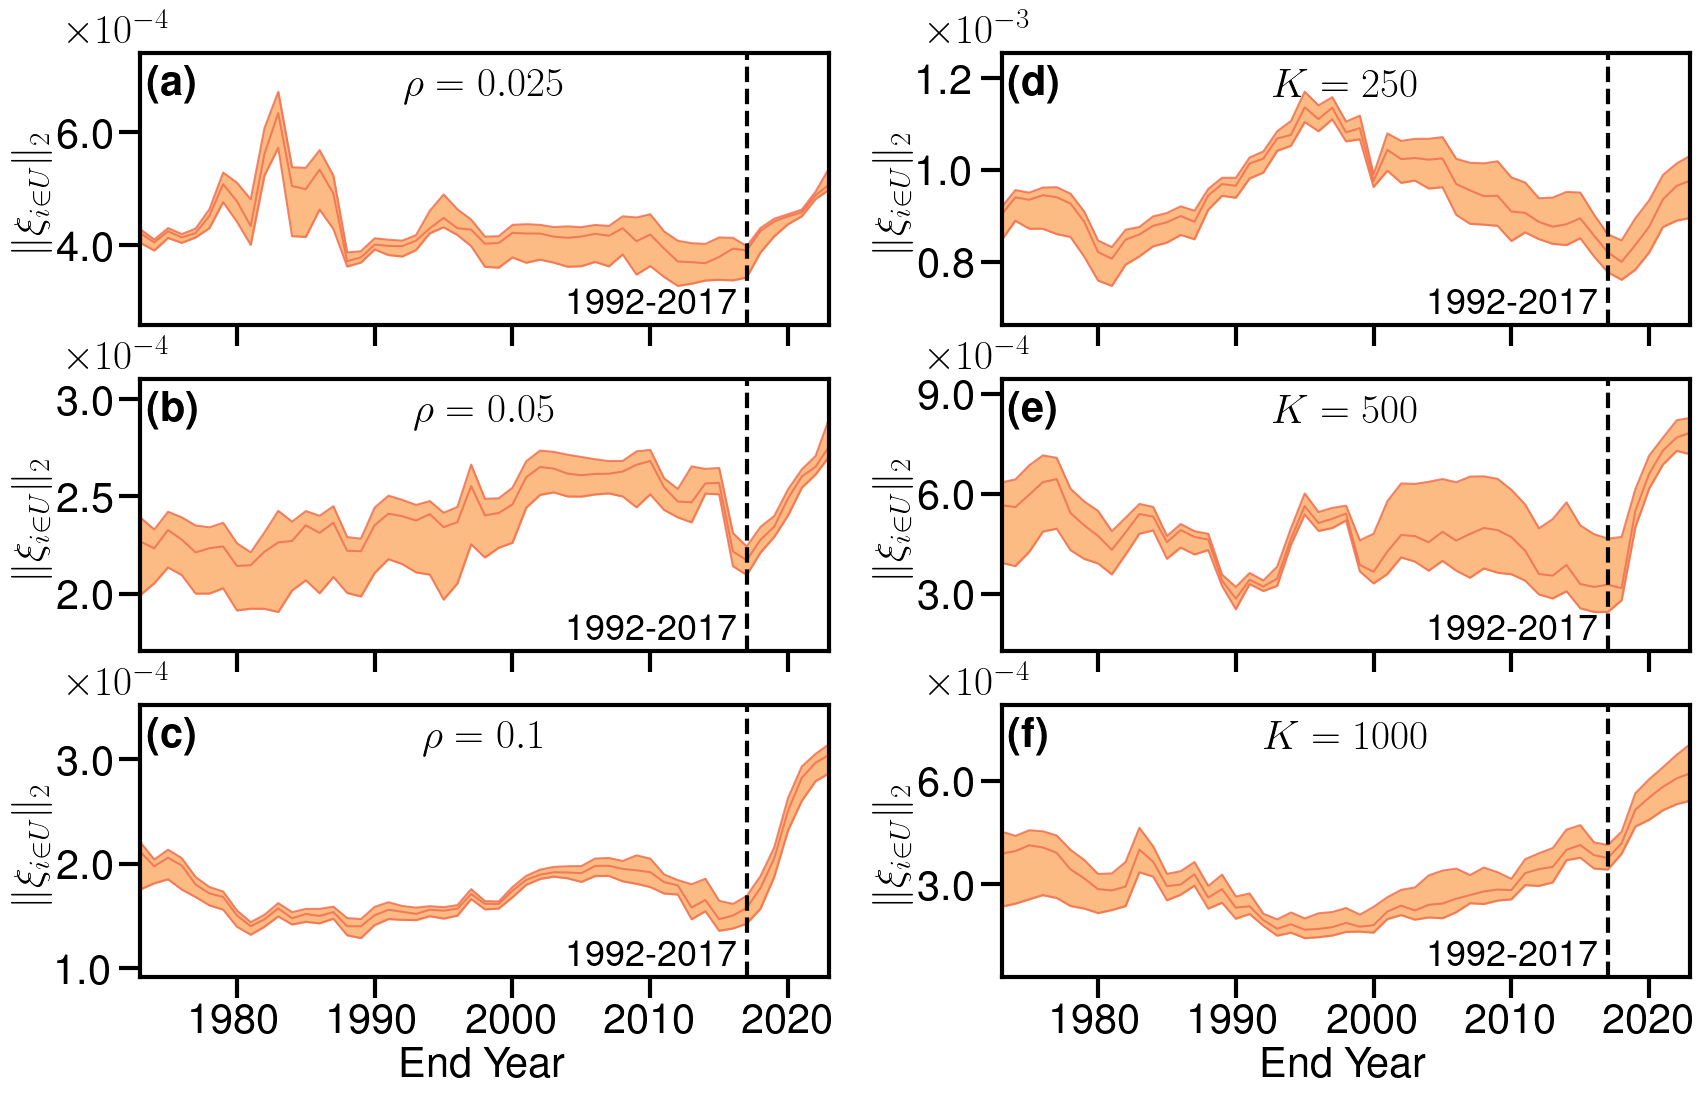

In [19]:
from matplotlib.ticker import ScalarFormatter

class MagnitudeFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

def mid_and_bounds(data,p_val,mid_function=np.median):
  low, upp, mid = [], [], []
  for i in range(len(data)):
    low.append(np.percentile(data[i], p_val))
    upp.append(np.percentile(data[i], 100-p_val))
    mid.append(mid_function(data[i]))

  return low, upp, mid

fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

p_val = 25
alpha = 1
alpha_bounds = 0.75
color_bounds = '#fee8c8'
color = '#fdbb84'
color_mid = '#ef6548'
ms = 7.5
lw = 2
legendsize = 18

xy_annotate = (0.01, 0.85)

fig, axs = plt.subplots(max(len(ks),len(densities)), 2, sharex=True, sharey=False, figsize=(20,4*max(len(ks),len(densities))))

min_value = 0
max_value = 0

date_reference = '1992-2017'

for i in range(len(ks)+len(densities)):

  if i < len(densities):
    manifold_dist = [np.sqrt(np.sum(manifold_dict[densities[i]][date][:-1]**2,1))[amazon_nodes] for date in dates]
    title = r'$\rho=' + str(densities[i]) + r'$'
    ax = axs[i,0]

    if i == len(densities) - 1:
      ax.set_xlabel('End Year', fontsize=fontsize)
      ax.set_xticklabels(xticklabels, fontsize=fontsize)

    #   ax.tick_params(bottom=True, top=False, left=True, right=False)
    # elif i == 0:
    #   # handles, labels = ax.get_legend_handles_labels()

    #   # ax.legend(handles, labels, loc='upper right',prop={'size': legendsize})
    #   ax.tick_params(bottom=False, top=False, left=True, right=False)
    # else:
    #   ax.tick_params(bottom=False, top=False, left=True, right=False)
  else:
    manifold_dist = [np.sqrt(np.sum(manifold_dict[ks[i-len(densities)]][date][:-1]**2,1))[amazon_nodes] for date in dates]
    title = r'$K=' + str(ks[i-len(densities)]) + r'$'
    ax = axs[i-len(densities),1]

    if i == len(densities) + len(ks) - 1:
      ax.set_xlabel('End Year', fontsize=fontsize)
      ax.set_xticklabels(xticklabels, fontsize=fontsize)

    #   ax.tick_params(bottom=True, top=False, left=True, right=False)
    # elif i == len(densities):
    #   # handles, labels = ax.get_legend_handles_labels()

    #   # ax.legend(handles, labels, loc='upper right',prop={'size': legendsize})
    #   ax.tick_params(bottom=False, top=False, left=True, right=False)
    # else:
    #   ax.tick_params(bottom=False, top=False, left=True, right=False)

  # low, upp, mid = mid_and_bounds(manifold_dist, 5)

  # ax.plot(np.arange(len(dates)),mid,color,alpha=alpha_bounds,zorder=2)
  # ax.plot(np.arange(len(dates)),low,'-',c=color,alpha=alpha_bounds,zorder=2)
  # ax.plot(np.arange(len(dates)),upp,'-',c=color,alpha=alpha_bounds,zorder=2)
  # ax.fill_between(np.arange(len(dates)),low, upp, color=color_bounds,
  #                 alpha=alpha,zorder=1)

  low, upp, mid = mid_and_bounds(manifold_dist, p_val)

  ax.plot(np.arange(len(dates)),mid,color_mid,alpha=alpha_bounds,zorder=2)
  ax.plot(np.arange(len(dates)),low,'-',c=color_mid,alpha=alpha_bounds,zorder=2)
  ax.plot(np.arange(len(dates)),upp,'-',c=color_mid,alpha=alpha_bounds,zorder=2)
  ax.fill_between(np.arange(len(dates)),low, upp, color=color,
                  alpha=alpha,zorder=1)

  min_value = np.min(low)
  max_value = np.max(upp)


  ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, xycoords='axes fraction', fontsize=fontsize)

  xticks = np.arange(7,len(dates),10)
  xticklabels = [dates[i].split('-')[1] for i in xticks]
  ax.set_xticks(xticks)

  # if i < len(densities):
  ax.set_ylabel(r'$\|\vec{\xi}_{i\in U}\|_2$', fontsize=fontsize)



  # if i == len(densities) or i == len(ks):
  #   ax.set_xlabel('End Year', fontsize=fontsize)
  #   ax.set_xticklabels(xticklabels, fontsize=fontsize)

  #   ax.tick_params(bottom=True, top=False, left=True, right=False)
  # elif i == 0 or i == len(densities):
  #   handles, labels = ax.get_legend_handles_labels()

  #   ax.legend(handles, labels, loc='upper right',prop={'size': legendsize})
  #   ax.tick_params(bottom=False, top=False, left=True, right=False)
  # else:
  #   ax.tick_params(bottom=False, top=False, left=True, right=False)


  # ax.set_title(title, fontsize=fontsize)
  ax.annotate(title, xy=(0.5,0.95), xycoords='axes fraction', ha='center', va='top', fontsize=fontsize)

  ax.set_xlim(0,len(dates)-1)

  ax.tick_params(length=15,width=3)
  plt.setp(ax.spines.values(), linewidth=3, zorder=10)

  # fmt = ScalarFormatter()
  # fmt.set_powerlimits((-3,3))
  # ax.yaxis.set_major_formatter(fmt)
  # plt.ticklabel_format(style='sci', axis='y')
  # print(ax.yaxis.get_major_formatter().__dict__)

  ax.set_xlim(0,len(dates)-1)
  ax.set_ylim(min_value-0.2*(max_value-min_value),max_value+0.2*(max_value-min_value))

  ax.plot([dates.index(date_reference)]*2,[min_value-0.2*(max_value-min_value),max_value+0.2*(max_value-min_value)], 'k--', lw=3)
  ax.annotate(date_reference, xy=(dates.index(date_reference)-0.5,min_value-0.175*(max_value-min_value)),
              xycoords='data', ha='right', va='bottom', fontsize=fontsize-4)

  ax.yaxis.set_major_locator(plt.MaxNLocator(3))



  yticks = ax.get_yticks()[1:-1]

  multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
  fmt = MagnitudeFormatter(multiplier)
  ax.yaxis.set_major_formatter(fmt)
  # plt.ticklabel_format(style='sci', axis='y')
  # print(ax.yaxis.get_major_formatter().__dict__)
  ax.yaxis.offsetText.set_visible(False)

  # print(yticks)
  ax.set_yticks(yticks)
  ax.set_yticklabels(['{:.1f}'.format(ytick/10**multiplier) for ytick in yticks])

  if multiplier != 0:
      ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.105,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)

plt.subplots_adjust(hspace=0.2, wspace=0.25)

fig.align_labels()

title = 'Manifold Distances'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

In [ ]:
with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'wb') as file:
  pkl.dump(manifold_dict, file)

## Undirected

In [ ]:
months = 300
offset = 365.25
density = 0.005

edge_dir = data_dir + 'edge_list-months='+str(months)+',offset='+str(offset)+',density={:}'.format(density)+'/'
graph_dir = data_dir + 'G-months='+str(months)+',offset='+str(offset)+',density={:}'.format(density)+'/'

dir_end = '-months={:},offset={:},density={:}/'.format(months,offset,density)

total_networks = len(os.listdir(edge_dir))

num_nodes = 10242

with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'rb') as file:
  year_intervals = pkl.load(file)

with gzip.open(data_dir + 'date_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'rb') as file:
  date_intervals = pkl.load(file)

dates = [year_intervals[i][0] + '-' + year_intervals[i][1] for i in range(len(year_intervals))]

with gzip.open(data_dir + 'icosahedral_grid.data', 'rb') as file:
    latlon_icos = np.array(pkl.load(file))

recompute = False

if recompute:
  amazon_nodes = []

  reader = shpreader.Reader(base_dir+'Amazon Biome/amazonia.shp')
  amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())

  for i in range(num_nodes):
    if amazon._geoms[0].contains(Point(latlon_icos[i,1]-360,latlon_icos[i,0])):
      amazon_nodes.append(i)

  with gzip.open(data_dir + 'amazon_nodes_new_networks.data', 'wb') as file:
    pkl.dump(amazon_nodes, file)
else:
  with gzip.open(data_dir + 'amazon_nodes_new_networks.data', 'rb') as file:
    amazon_nodes = pkl.load(file)

In [ ]:
for date in dates:
  with gzip.open(graph_dir + date + '.data', 'rb') as file:
    G = pkl.load(file)

  print(date, nx.number_connected_components(G), G.number_of_edges(), min([d[1] for d in G.degree]))

In [ ]:
manifold_dir = data_dir + 'Manifolds/'
if not os.path.isdir(manifold_dir):
  os.mkdir(manifold_dir)

recompute = False
if recompute:
  manifold_dict = {}
  for date in tqdm(dates):
    with gzip.open(graph_dir + date + '.data', 'rb') as file:
      G = pkl.load(file)
    manifold_dict[date] = manifold.spectral_embedding(nx.to_numpy_array(G),n_components=4,drop_first=True)

  with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'wb') as file:
    pkl.dump(manifold_dict, file)
else:
  with gzip.open(manifold_dir + 'manifold4d_dict'+dir_end[:-1]+'.data', 'rb') as file:
    manifold_dict = pkl.load(file)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
manifold_dir = data_dir + 'Manifolds/'
if not os.path.isdir(manifold_dir):
  os.mkdir(manifold_dir)

recompute = False
if recompute:
  manifold_dict_no_amazon_edges = {}
  for date in tqdm(dates):
    with gzip.open(graph_dir + date + '.data', 'rb') as file:
      G = pkl.load(file)

    all_edges = np.array([sorted(e) for e in G.edges])
    edges = all_edges[np.union1d(np.where(np.in1d(all_edges[:,0],amazon_nodes) == True)[0],np.where(np.in1d(all_edges[:,1],amazon_nodes) == True)[0])]
    edges_in = edges[np.intersect1d(np.where(np.in1d(edges[:,0],amazon_nodes) == True)[0],np.where(np.in1d(edges[:,1],amazon_nodes) == True)[0])]

    G.remove_edges_from(edges_in)
    manifold_dict_no_amazon_edges[date] = manifold.spectral_embedding(nx.to_numpy_array(G),n_components=4,drop_first=True)

  with gzip.open(manifold_dir + 'manifold4d_dict_no_amazon_edges'+dir_end[:-1]+'.data', 'wb') as file:
    pkl.dump(manifold_dict_no_amazon_edges, file)
else:
  with gzip.open(manifold_dir + 'manifold4d_dict_no_amazon_edges'+dir_end[:-1]+'.data', 'rb') as file:
    manifold_dict_no_amazon_edges = pkl.load(file)

In [ ]:
x1pma = np.zeros((len(dates),len(amazon_nodes),4))
for i in trange(len(dates)):
  x1 = manifold_dict[dates[i]][amazon_nodes,0]
  x2 = manifold_dict[dates[i]][amazon_nodes,1]
  x3 = manifold_dict[dates[i]][amazon_nodes,2]
  x4 = manifold_dict[dates[i]][amazon_nodes,3]
  x1pma[i,:,0] = x1; x1pma[i,:,1] = x2; x1pma[i,:,2] = x3; x1pma[i,:,3] = x4

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
x1pma_no_amazon_edges = np.zeros((len(dates),len(amazon_nodes),4))
for i in trange(len(dates)):
  x1 = manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,0]
  x2 = manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,1]
  x3 = manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,2]
  x4 = manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,3]
  if i == 50:
    x1 *= -1

  x1pma_no_amazon_edges[i,:,0] = x1; x1pma_no_amazon_edges[i,:,1] = x2; x1pma_no_amazon_edges[i,:,2] = x3; x1pma_no_amazon_edges[i,:,3] = x4

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
fontsize = 18

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig = plt.figure(figsize=(20, 100))
#ax1 = plt.axes(xlim=(-.00035,.00055), ylim=(-.00035,.00055))
#line, = ax1.plot([],[])
plt.title(dates[0], loc='center', fontsize=18)
plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18)

#ax1=plt.subplot(5,5,1)
#line1 = ax1.plot(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],'o',color='blue',label='Non-Amazon Nodes')[0]
#line2 = ax1.plot(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')[0]
#line1 = ax1.scatter(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],
#                    s=20,marker='o',label='Non-Amazon Nodes')
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                    s=20,marker='p',label='Amazon Nodes')

#plt.title(dates[i], loc='center', fontsize=18)
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')


#plt.legend(loc='upper right',prop={'size': 15})

def update(i,j):
    ax1=plt.subplot(30,5,i-j+1)

    line1 = ax1.scatter(manifold_dict[dates[i]][:,0],manifold_dict[dates[i]][:,1],
                    s=20,c=manifold_dict[dates[i]][:,2],marker='o',label='Non-Amazon Nodes')
    line2 = ax1.scatter(manifold_dict[dates[i]][amazon_nodes,0],
                        manifold_dict[dates[i]][amazon_nodes,1],
                    s=20,c='red',marker='p',label='Amazon Nodes')

    plt.title(dates[i], loc='center', fontsize=18)
#

#def update(i):
#    line1.set_data(manifold_full_rank_dict[dates[i]][:,0],manifold_full_rank_dict[dates[i]][:,1])
#    line2.set_data(manifold_full_rank_dict[dates[i]][amazon_nodes,0],manifold_full_rank_dict[dates[i]][amazon_nodes,1])
#    plt.title(dates[i], loc='center', fontsize=18)
#    return line1,line2,ax1

for i in range(len(dates)):
    update(i,0)


plt.subplots_adjust(wspace=0.4,hspace=0.4)

#ani = animation.FuncAnimation(fig, update, frames=len(dates))
#writer = animation.PillowWriter(fps=2)
#ani.save(fig_dir+'Manifolds_Full_Rank.gif', writer=writer, dpi=200)
#plt.close(fig)

title = 'Manifolds'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-12-47aa8c01e6b2>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')
<ipython-input-12-47aa8c01e6b2>:148: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 5
<ipython-input-12-47aa8c01e6b2>:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-12-47aa8c01e6b2>:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


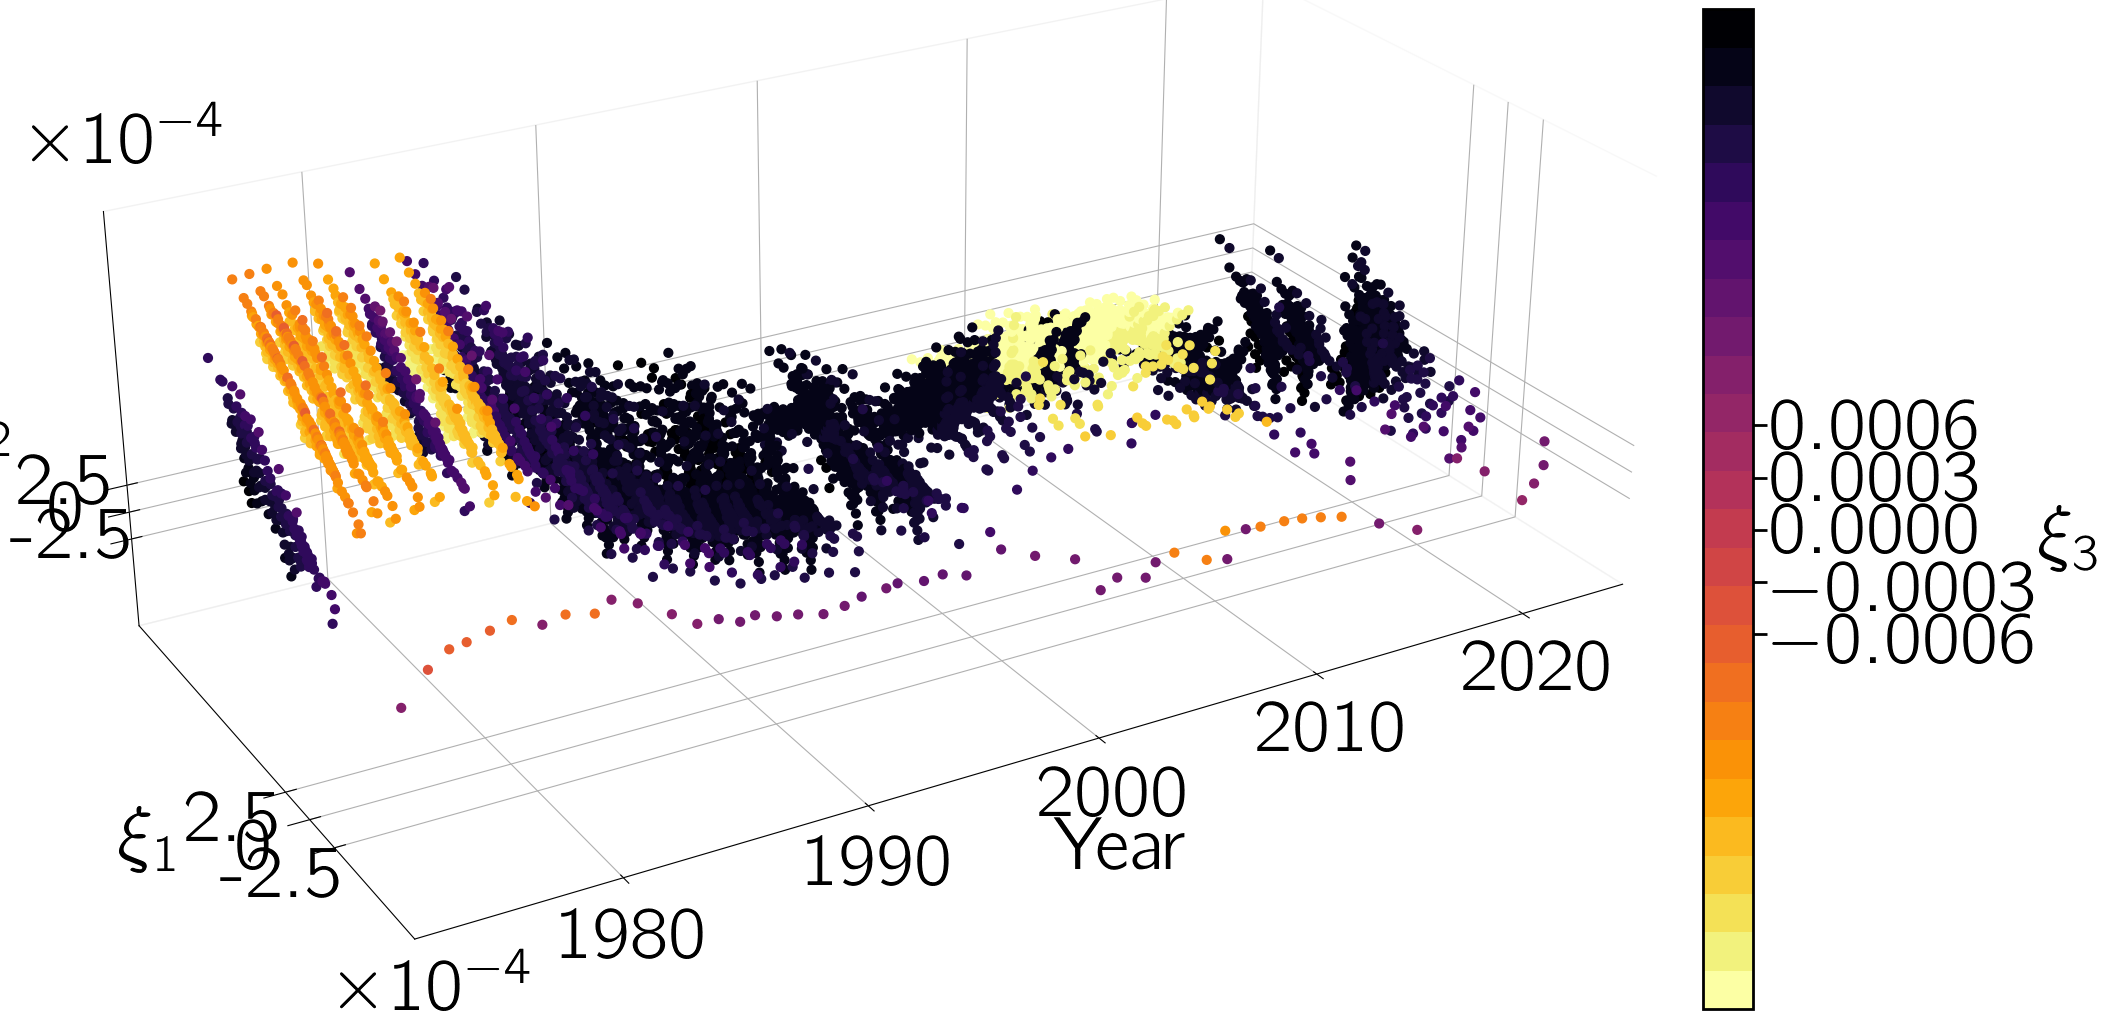

In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']


fontsize = 54

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig, axs = plt.subplots(1,1,sharex=True,figsize=(20,10))
#                         constrained_layout=True)
# ax1 = plt.subplot(4,2,1)
# ax2 = plt.subplot(4,2,2)
# ax3 = plt.subplot(4,2,3)
# ax4 = plt.subplot(4,2,4)
# ax5 = plt.subplot(1,2,2)


ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')





### AXIS 1, 3D MANIFOLDS
scale_x, scale_y, scale_z = 3, 1.5, 1
# ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax4), np.diag([scale_x, scale_y, scale_z, 1]))
ax1.set_box_aspect(aspect = (scale_x,scale_y,scale_z), zoom=1)
# ax1.auto_scale_xyz([0, len(dates)], [-0.0002,0.000125], [-0.0002,0.000175])
# ax1.pbaspect = [scale_x, scale_y, scale_z]
# ax1.dist = 5


# scale=np.diag([scale_x, scale_y, scale_z, 1.0])
# scale=scale*(1.0/scale.max())
# scale[3,3]=1.0

# def short_proj():
#     return np.dot(Axes3D.get_proj(ax1), scale)

# ax1.get_proj=short_proj

lw = 5

cmap = plt.get_cmap('inferno_r', 26)

# for i in range(0,len(dates)):
#     p=ax1.scatter(i,x1pma[i,:,0],x1pma[i,:,1],c=x1pma[i,:,2],s=40,marker='o',
#                   cmap=cmap,alpha=1.0,clip_on=False,vmin=-0.0007, vmax=0.0007)

vmin = np.min(x1pma[:,:,2])
vmax = np.max(x1pma[:,:,2])

dim1_min = np.min(x1pma[:,:,0])
dim1_max = np.max(x1pma[:,:,0])
dim2_min = np.min(x1pma[:,:,1])
dim2_max = np.max(x1pma[:,:,1])

p=ax1.scatter(np.array([i for i in range(len(dates)) for _ in range(x1pma[:,:,0].shape[1])]),
              np.ravel(x1pma[:,:,0]),np.ravel(x1pma[:,:,1]),c=np.ravel(x1pma[:,:,2]),
              s=40,marker='o',cmap=cmap,alpha=1.0,clip_on=False,vmin=vmin, vmax=vmax,
              zorder=5)




#ax.set_yticklabels([1973,1983,1993,2003,2013])

# #ax.grid(False)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

labelpad = 20
ax1.set_xlabel(r'Year',fontsize=fontsize,labelpad=labelpad)

labelpad = 5
ax1.set_ylabel(r'$\xi_1$',fontsize=fontsize,labelpad=labelpad)
ax1.set_zlabel(r'$\xi_2$',fontsize=fontsize,labelpad=labelpad)

ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)

# ax1.text(13,-0.00065,0.0,"Year",fontsize=fontsize);
# ax1.text(-8,-0.00005,-0.00025,r'$\xi_1$',fontsize=fontsize);
# ax1.text(-9,-0.0,0.00006,r'$\xi_2$',fontsize=fontsize);

cax = fig.add_axes([.925, -.1, .025, 1])

ticks = [-.0006, -.0003, 0, 0.0003, 0.0006]
cbar=plt.colorbar(p, cax=cax, ticks=ticks, orientation='vertical')
cbar.set_label(r'$\xi_3$',fontsize=fontsize,rotation=0,labelpad=20)

ax1.tick_params(length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=2)

cbar.ax.tick_params(length=10,width=2)
plt.setp(cbar.ax.spines.values(), linewidth=2)

# cbar.ax.set_yticklabels(ticks,fontsize=fontsize)






# ax1.set_ylim3d(-0.0002,0.000125)
# ax1.set_zlim3d(-0.0002,0.000175)
ax1.set_ylim3d(dim1_min,dim1_max)
ax1.set_zlim3d(dim2_min,dim2_max)
ax1.set_xlim3d(0,len(dates))

# ax1.view_init(25, 260)
ax1.view_init(25, 240)


ticks = [7, 17, 27, 37, 47]
ax1.set_xticks(ticks)
ax1.set_xticklabels([dates[i][5:] for i in ticks])
# ax1.set_xticks([2,17,32,47])
# ax1.set_xticklabels([1975,1990,2005,2020],fontsize=fontsize)


ticks = [-.00025, 0, .00025]
ax1.set_yticks(ticks)
ax1.set_yticklabels(['-2.5', '0', '2.5'], va='center')
# ax1.set_yticklabels(["{:.1e}".format(tick) for tick in ticks])

ticks = [-.00025, 0, .00025]
ax1.set_zticks(ticks)
ax1.set_zticklabels(['-2.5', '0', '2.5'], va='center')
# ax1.set_zticklabels(["{:.1e}".format(tick) for tick in ticks])

ax1.annotate(r'$\times 10^{-4}$', xy=(-.6, .9), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')
ax1.annotate(r'$\times 10^{-4}$', xy=(-.2, -.2), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')

# ax1.set_yticks([-0.0001,0.0001])
# ax1.set_yticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.set_zticks([-0.0001,0.0001])
# ax1.set_zticklabels([-0.0001,0.0001],fontsize=fontsize)

ax1.dist = 5



fig.tight_layout()

title = 'Manifold'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

In [ ]:
inds_to_flip_1 = [14] + list(range(21,len(dates)))
for i in inds_to_flip_1:
  manifold_dict[dates[i]][:,1] *= -1

In [ ]:
inds_to_flip_2 = [0] + list(range(17,25)) + list(range(26,36)) + list(range(43,len(dates)))
for i in inds_to_flip_2:
  manifold_dict[dates[i]][:,2] *= -1

In [ ]:
fontsize = 18

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig = plt.figure(figsize=(20, 100))
#ax1 = plt.axes(xlim=(-.00035,.00055), ylim=(-.00035,.00055))
#line, = ax1.plot([],[])
plt.title(dates[0], loc='center', fontsize=18)
plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18)

#ax1=plt.subplot(5,5,1)
#line1 = ax1.plot(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],'o',color='blue',label='Non-Amazon Nodes')[0]
#line2 = ax1.plot(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')[0]
#line1 = ax1.scatter(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],
#                    s=20,marker='o',label='Non-Amazon Nodes')
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                    s=20,marker='p',label='Amazon Nodes')

#plt.title(dates[i], loc='center', fontsize=18)
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')


#plt.legend(loc='upper right',prop={'size': 15})

def update(i,j):
    ax1=plt.subplot(30,5,i-j+1)

    line1 = ax1.scatter(manifold_dict[dates[i]][:,0],manifold_dict[dates[i]][:,1],
                    s=20,c=manifold_dict[dates[i]][:,2],marker='o',label='Non-Amazon Nodes')
    line2 = ax1.scatter(manifold_dict[dates[i]][amazon_nodes,0],
                        manifold_dict[dates[i]][amazon_nodes,1],
                    s=20,c='red',marker='p',label='Amazon Nodes')

    plt.title(dates[i], loc='center', fontsize=18)
#

#def update(i):
#    line1.set_data(manifold_full_rank_dict[dates[i]][:,0],manifold_full_rank_dict[dates[i]][:,1])
#    line2.set_data(manifold_full_rank_dict[dates[i]][amazon_nodes,0],manifold_full_rank_dict[dates[i]][amazon_nodes,1])
#    plt.title(dates[i], loc='center', fontsize=18)
#    return line1,line2,ax1

for i in range(len(dates)):
    update(i,0)


plt.subplots_adjust(wspace=0.4,hspace=0.4)

#ani = animation.FuncAnimation(fig, update, frames=len(dates))
#writer = animation.PillowWriter(fps=2)
#ani.save(fig_dir+'Manifolds_Full_Rank.gif', writer=writer, dpi=200)
#plt.close(fig)

title = 'Manifolds'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-51-47aa8c01e6b2>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')
<ipython-input-51-47aa8c01e6b2>:148: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 5
<ipython-input-51-47aa8c01e6b2>:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-51-47aa8c01e6b2>:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


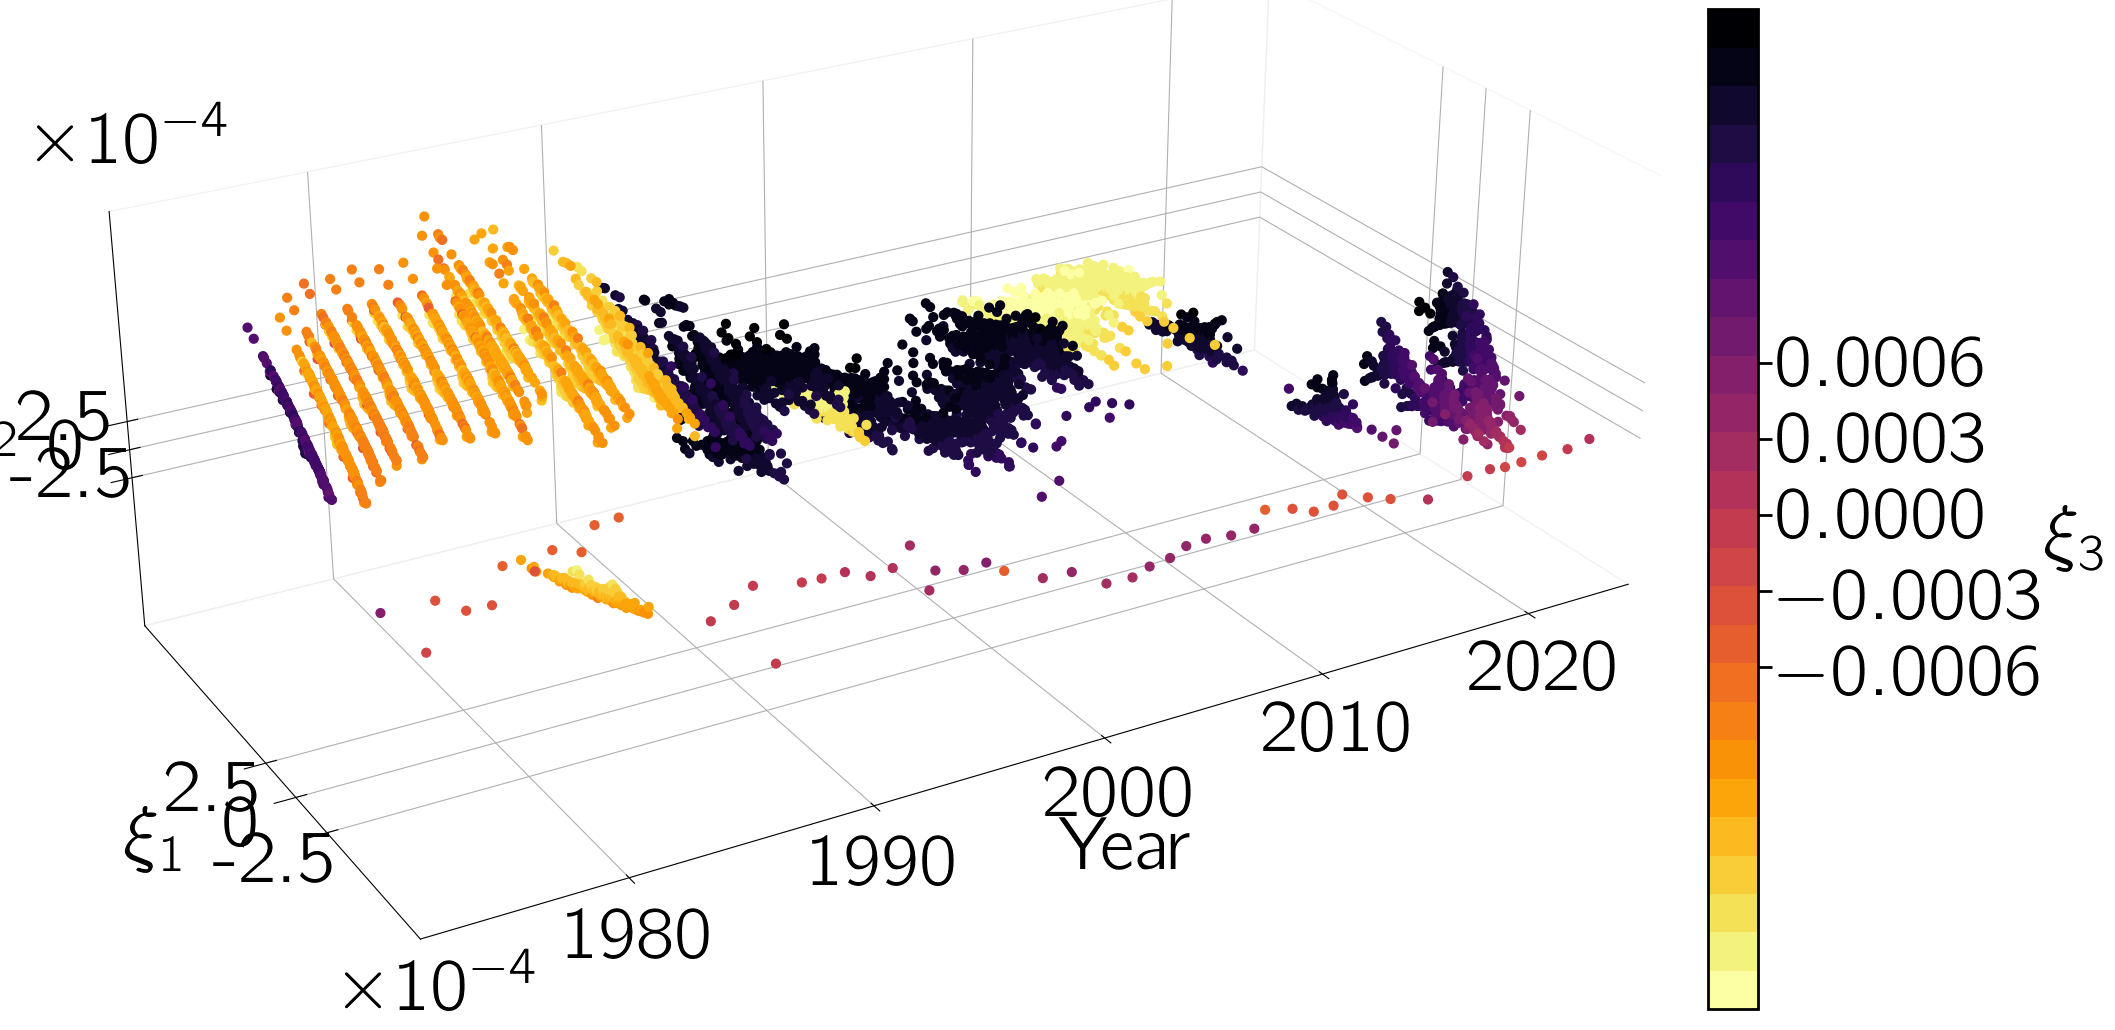

In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']


fontsize = 54

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig, axs = plt.subplots(1,1,sharex=True,figsize=(20,10))
#                         constrained_layout=True)
# ax1 = plt.subplot(4,2,1)
# ax2 = plt.subplot(4,2,2)
# ax3 = plt.subplot(4,2,3)
# ax4 = plt.subplot(4,2,4)
# ax5 = plt.subplot(1,2,2)


ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')





### AXIS 1, 3D MANIFOLDS
scale_x, scale_y, scale_z = 3, 1.5, 1
# ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax4), np.diag([scale_x, scale_y, scale_z, 1]))
ax1.set_box_aspect(aspect = (scale_x,scale_y,scale_z), zoom=1)
# ax1.auto_scale_xyz([0, len(dates)], [-0.0002,0.000125], [-0.0002,0.000175])
# ax1.pbaspect = [scale_x, scale_y, scale_z]
# ax1.dist = 5


# scale=np.diag([scale_x, scale_y, scale_z, 1.0])
# scale=scale*(1.0/scale.max())
# scale[3,3]=1.0

# def short_proj():
#     return np.dot(Axes3D.get_proj(ax1), scale)

# ax1.get_proj=short_proj

lw = 5

cmap = plt.get_cmap('inferno_r', 26)

# for i in range(0,len(dates)):
#     p=ax1.scatter(i,x1pma[i,:,0],x1pma[i,:,1],c=x1pma[i,:,2],s=40,marker='o',
#                   cmap=cmap,alpha=1.0,clip_on=False,vmin=-0.0007, vmax=0.0007)

vmin = np.min(x1pma[:,:,2])
vmax = np.max(x1pma[:,:,2])

dim1_min = np.min(x1pma[:,:,0])
dim1_max = np.max(x1pma[:,:,0])
dim2_min = np.min(x1pma[:,:,1])
dim2_max = np.max(x1pma[:,:,1])

p=ax1.scatter(np.array([i for i in range(len(dates)) for _ in range(x1pma[:,:,0].shape[1])]),
              np.ravel(x1pma[:,:,0]),np.ravel(x1pma[:,:,1]),c=np.ravel(x1pma[:,:,2]),
              s=40,marker='o',cmap=cmap,alpha=1.0,clip_on=False,vmin=vmin, vmax=vmax,
              zorder=5)




#ax.set_yticklabels([1973,1983,1993,2003,2013])

# #ax.grid(False)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

labelpad = 20
ax1.set_xlabel(r'Year',fontsize=fontsize,labelpad=labelpad)

labelpad = 5
ax1.set_ylabel(r'$\xi_1$',fontsize=fontsize,labelpad=labelpad)
ax1.set_zlabel(r'$\xi_2$',fontsize=fontsize,labelpad=labelpad)

ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)

# ax1.text(13,-0.00065,0.0,"Year",fontsize=fontsize);
# ax1.text(-8,-0.00005,-0.00025,r'$\xi_1$',fontsize=fontsize);
# ax1.text(-9,-0.0,0.00006,r'$\xi_2$',fontsize=fontsize);

cax = fig.add_axes([.925, -.1, .025, 1])

ticks = [-.0006, -.0003, 0, 0.0003, 0.0006]
cbar=plt.colorbar(p, cax=cax, ticks=ticks, orientation='vertical')
cbar.set_label(r'$\xi_3$',fontsize=fontsize,rotation=0,labelpad=20)

ax1.tick_params(length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=2)

cbar.ax.tick_params(length=10,width=2)
plt.setp(cbar.ax.spines.values(), linewidth=2)

# cbar.ax.set_yticklabels(ticks,fontsize=fontsize)






# ax1.set_ylim3d(-0.0002,0.000125)
# ax1.set_zlim3d(-0.0002,0.000175)
ax1.set_ylim3d(dim1_min,dim1_max)
ax1.set_zlim3d(dim2_min,dim2_max)
ax1.set_xlim3d(0,len(dates))

# ax1.view_init(25, 260)
ax1.view_init(25, 240)


ticks = [7, 17, 27, 37, 47]
ax1.set_xticks(ticks)
ax1.set_xticklabels([dates[i][5:] for i in ticks])
# ax1.set_xticks([2,17,32,47])
# ax1.set_xticklabels([1975,1990,2005,2020],fontsize=fontsize)


ticks = [-.00025, 0, .00025]
ax1.set_yticks(ticks)
ax1.set_yticklabels(['-2.5', '0', '2.5'], va='center')
# ax1.set_yticklabels(["{:.1e}".format(tick) for tick in ticks])

ticks = [-.00025, 0, .00025]
ax1.set_zticks(ticks)
ax1.set_zticklabels(['-2.5', '0', '2.5'], va='center')
# ax1.set_zticklabels(["{:.1e}".format(tick) for tick in ticks])

ax1.annotate(r'$\times 10^{-4}$', xy=(-.6, .9), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')
ax1.annotate(r'$\times 10^{-4}$', xy=(-.2, -.2), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')

# ax1.set_yticks([-0.0001,0.0001])
# ax1.set_yticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.set_zticks([-0.0001,0.0001])
# ax1.set_zticklabels([-0.0001,0.0001],fontsize=fontsize)

ax1.dist = 5



fig.tight_layout()

title = 'Manifold'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

In [ ]:
x1pma_no_amazon_edges = np.zeros((len(dates),len(amazon_nodes),4))
for i in trange(len(dates)):
  x1 = manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,0]
  x2 = manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,1]
  x3 = manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,2]
  x4 = manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,3]
  if i == 50:
    x1 *= -1

  x1pma_no_amazon_edges[i,:,0] = x1; x1pma_no_amazon_edges[i,:,1] = x2; x1pma_no_amazon_edges[i,:,2] = x3; x1pma_no_amazon_edges[i,:,3] = x4

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
x1pma = np.zeros((len(dates),len(amazon_nodes),4))
for i in trange(len(dates)):
  x1 = manifold_dict[dates[i]][amazon_nodes,0]
  x2 = manifold_dict[dates[i]][amazon_nodes,1]
  x3 = manifold_dict[dates[i]][amazon_nodes,2]
  x4 = manifold_dict[dates[i]][amazon_nodes,3]
  x1pma[i,:,0] = x1; x1pma[i,:,1] = x2; x1pma[i,:,2] = x3; x1pma[i,:,3] = x4

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
x2pma = [None]*len(dates)
for i in trange(len(dates)):
  with gzip.open(graph_dir + dates[i] + '.data', 'rb') as file:
    G = pkl.load(file)
  amazon_neighbors = list(G.neighbors(amazon_nodes[0]))
  for j in range(1,len(amazon_nodes)):
    amazon_neighbors = np.union1d(amazon_neighbors,list(G.neighbors(amazon_nodes[j])))
  amazon_neighbors.sort()
  amazon_neighbors = np.setdiff1d(amazon_neighbors,amazon_nodes)

  x1 = manifold_dict[dates[i]][amazon_neighbors,0]
  x2 = manifold_dict[dates[i]][amazon_neighbors,1]
  x3 = manifold_dict[dates[i]][amazon_neighbors,2]
  x4 = manifold_dict[dates[i]][amazon_neighbors,3]
  x2pma[i] = [x1, x2, x3, x4]

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
manifold_dict[dates[7]][:,1] *= -1
manifold_dict[dates[8]][:,1] *= -1
manifold_dict[dates[15]][:,1] *= -1
manifold_dict[dates[16]][:,1] *= -1
manifold_dict[dates[17]][:,1] *= -1
manifold_dict[dates[18]][:,1] *= -1
manifold_dict[dates[19]][:,1] *= -1
manifold_dict[dates[20]][:,1] *= -1
manifold_dict[dates[25]][:,1] *= -1
manifold_dict[dates[26]][:,1] *= -1
manifold_dict[dates[27]][:,1] *= -1
manifold_dict[dates[28]][:,1] *= -1
manifold_dict[dates[29]][:,1] *= -1
manifold_dict[dates[30]][:,1] *= -1
manifold_dict[dates[31]][:,1] *= -1
manifold_dict[dates[32]][:,1] *= -1
manifold_dict[dates[33]][:,1] *= -1
manifold_dict[dates[34]][:,1] *= -1
manifold_dict[dates[35]][:,1] *= -1


manifold_dict[dates[47]][:,2] *= -1
manifold_dict[dates[48]][:,2] *= -1
manifold_dict[dates[50]][:,2] *= -1

In [ ]:
fontsize = 18

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig = plt.figure(figsize=(20, 100))
#ax1 = plt.axes(xlim=(-.00035,.00055), ylim=(-.00035,.00055))
#line, = ax1.plot([],[])
plt.title(dates[0], loc='center', fontsize=18)
plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18)

#ax1=plt.subplot(5,5,1)
#line1 = ax1.plot(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],'o',color='blue',label='Non-Amazon Nodes')[0]
#line2 = ax1.plot(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')[0]
#line1 = ax1.scatter(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],
#                    s=20,marker='o',label='Non-Amazon Nodes')
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                    s=20,marker='p',label='Amazon Nodes')

#plt.title(dates[i], loc='center', fontsize=18)
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')


#plt.legend(loc='upper right',prop={'size': 15})

def update(i,j):
    ax1=plt.subplot(30,5,i-j+1)

    line1 = ax1.scatter(manifold_dict[dates[i]][:,0],manifold_dict[dates[i]][:,1],
                    s=20,c=manifold_dict[dates[i]][:,2],marker='o',label='Non-Amazon Nodes')
    line2 = ax1.scatter(manifold_dict[dates[i]][amazon_nodes,0],
                        manifold_dict[dates[i]][amazon_nodes,1],
                    s=20,c='red',marker='p',label='Amazon Nodes')

    plt.title(dates[i], loc='center', fontsize=18)
#

#def update(i):
#    line1.set_data(manifold_full_rank_dict[dates[i]][:,0],manifold_full_rank_dict[dates[i]][:,1])
#    line2.set_data(manifold_full_rank_dict[dates[i]][amazon_nodes,0],manifold_full_rank_dict[dates[i]][amazon_nodes,1])
#    plt.title(dates[i], loc='center', fontsize=18)
#    return line1,line2,ax1

for i in range(len(dates)):
    update(i,0)


plt.subplots_adjust(wspace=0.4,hspace=0.4)

#ani = animation.FuncAnimation(fig, update, frames=len(dates))
#writer = animation.PillowWriter(fps=2)
#ani.save(fig_dir+'Manifolds_Full_Rank.gif', writer=writer, dpi=200)
#plt.close(fig)

title = 'Manifolds'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fontsize = 18

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig = plt.figure(figsize=(20, 100))
#ax1 = plt.axes(xlim=(-.00035,.00055), ylim=(-.00035,.00055))
#line, = ax1.plot([],[])
plt.title(dates[0], loc='center', fontsize=18)
plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18)

#ax1=plt.subplot(5,5,1)
#line1 = ax1.plot(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],'o',color='blue',label='Non-Amazon Nodes')[0]
#line2 = ax1.plot(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')[0]
#line1 = ax1.scatter(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],
#                    s=20,marker='o',label='Non-Amazon Nodes')
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                    s=20,marker='p',label='Amazon Nodes')

#plt.title(dates[i], loc='center', fontsize=18)
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')


#plt.legend(loc='upper right',prop={'size': 15})

def update(i,j):
    ax1=plt.subplot(30,5,i-j+1)

    line1 = ax1.scatter(manifold_dict_no_amazon_edges[dates[i]][:,0],manifold_dict_no_amazon_edges[dates[i]][:,1],
                    s=20,c=manifold_dict_no_amazon_edges[dates[i]][:,2],marker='o',label='Non-Amazon Nodes')
    line2 = ax1.scatter(manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,0],
                        manifold_dict_no_amazon_edges[dates[i]][amazon_nodes,1],
                    s=20,c='red',marker='p',label='Amazon Nodes')

    plt.title(dates[i], loc='center', fontsize=18)
#

#def update(i):
#    line1.set_data(manifold_full_rank_dict[dates[i]][:,0],manifold_full_rank_dict[dates[i]][:,1])
#    line2.set_data(manifold_full_rank_dict[dates[i]][amazon_nodes,0],manifold_full_rank_dict[dates[i]][amazon_nodes,1])
#    plt.title(dates[i], loc='center', fontsize=18)
#    return line1,line2,ax1

for i in range(len(dates)):
    update(i,0)


plt.subplots_adjust(wspace=0.4,hspace=0.4)

#ani = animation.FuncAnimation(fig, update, frames=len(dates))
#writer = animation.PillowWriter(fps=2)
#ani.save(fig_dir+'Manifolds_Full_Rank.gif', writer=writer, dpi=200)
#plt.close(fig)

title = 'Manifolds'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-32-47aa8c01e6b2>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')
<ipython-input-32-47aa8c01e6b2>:148: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 5
<ipython-input-32-47aa8c01e6b2>:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-32-47aa8c01e6b2>:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


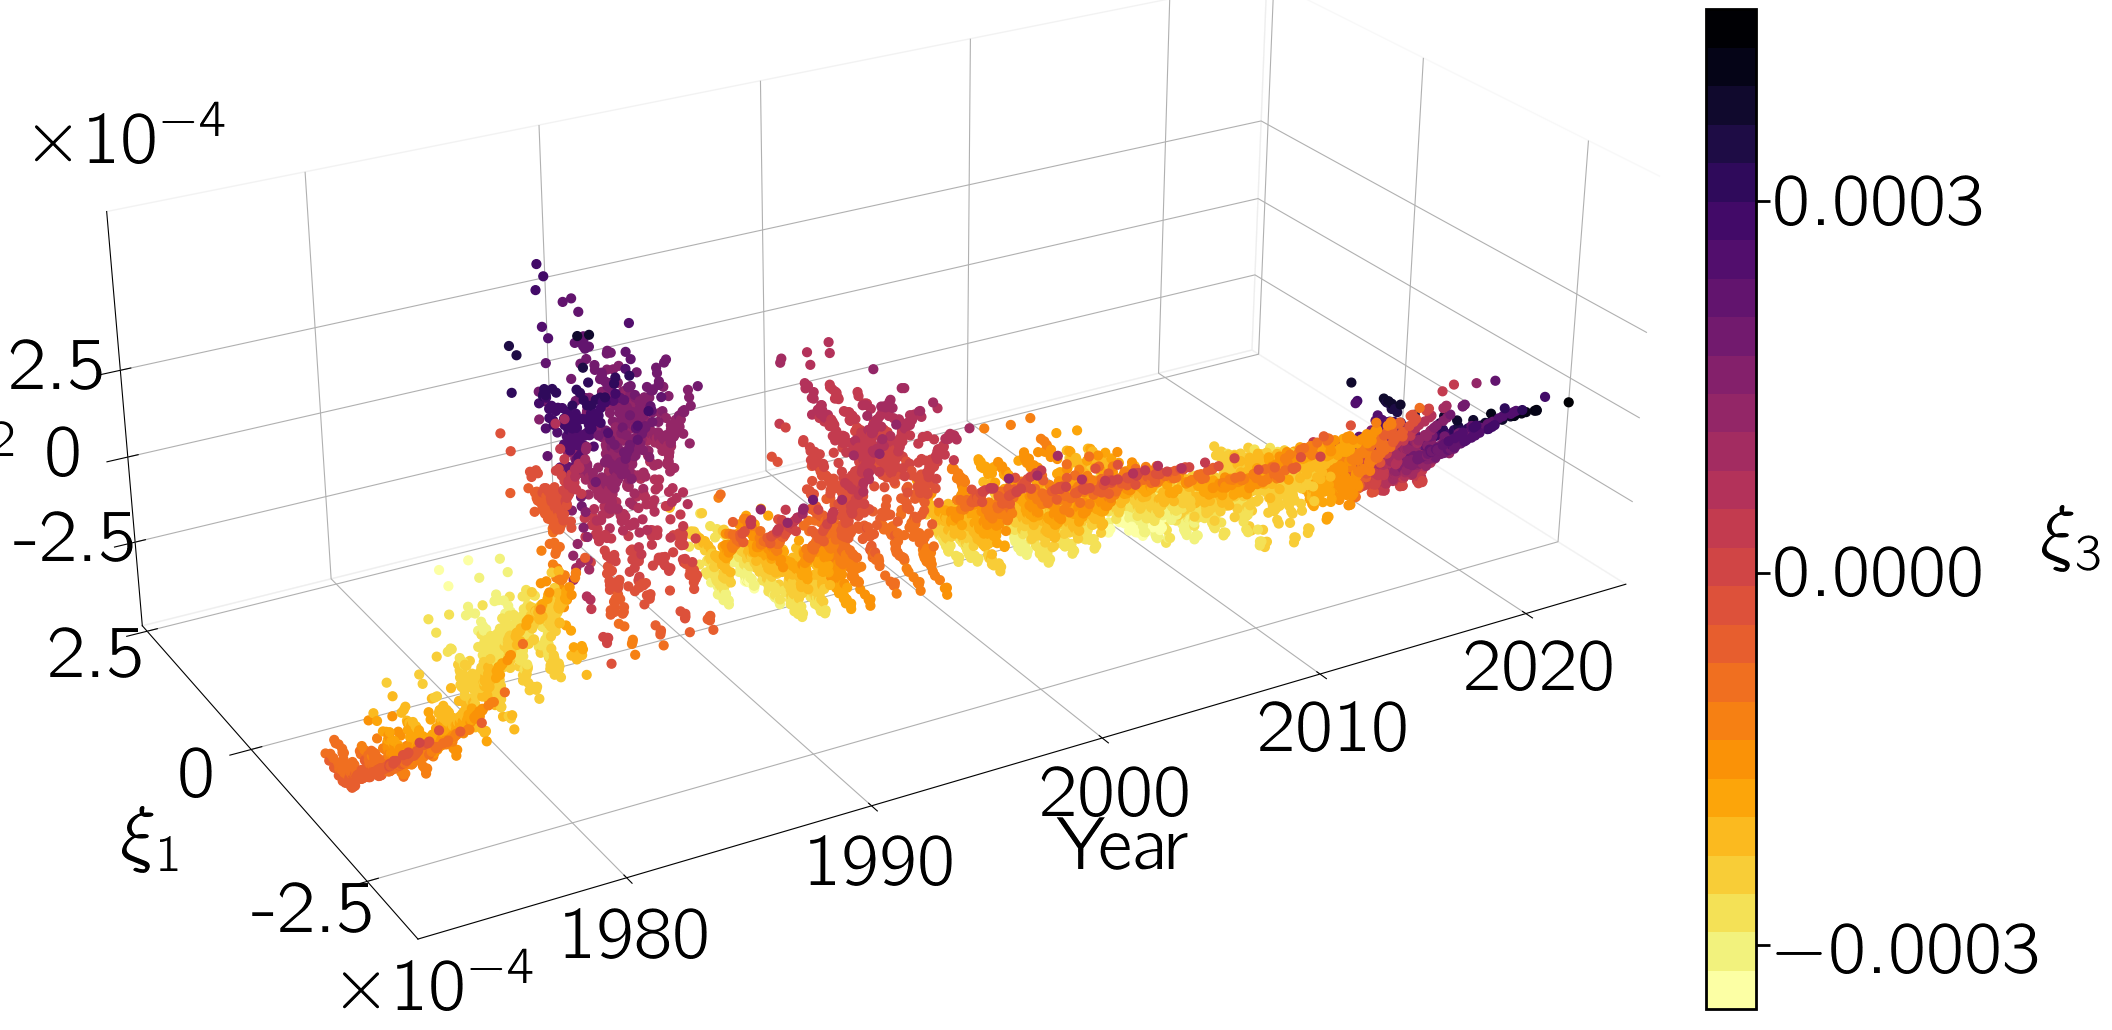

In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']


fontsize = 54

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig, axs = plt.subplots(1,1,sharex=True,figsize=(20,10))
#                         constrained_layout=True)
# ax1 = plt.subplot(4,2,1)
# ax2 = plt.subplot(4,2,2)
# ax3 = plt.subplot(4,2,3)
# ax4 = plt.subplot(4,2,4)
# ax5 = plt.subplot(1,2,2)


ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')





### AXIS 1, 3D MANIFOLDS
scale_x, scale_y, scale_z = 3, 1.5, 1
# ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax4), np.diag([scale_x, scale_y, scale_z, 1]))
ax1.set_box_aspect(aspect = (scale_x,scale_y,scale_z), zoom=1)
# ax1.auto_scale_xyz([0, len(dates)], [-0.0002,0.000125], [-0.0002,0.000175])
# ax1.pbaspect = [scale_x, scale_y, scale_z]
# ax1.dist = 5


# scale=np.diag([scale_x, scale_y, scale_z, 1.0])
# scale=scale*(1.0/scale.max())
# scale[3,3]=1.0

# def short_proj():
#     return np.dot(Axes3D.get_proj(ax1), scale)

# ax1.get_proj=short_proj

lw = 5

cmap = plt.get_cmap('inferno_r', 26)

# for i in range(0,len(dates)):
#     p=ax1.scatter(i,x1pma[i,:,0],x1pma[i,:,1],c=x1pma[i,:,2],s=40,marker='o',
#                   cmap=cmap,alpha=1.0,clip_on=False,vmin=-0.0007, vmax=0.0007)

vmin = np.min(x1pma[:,:,2])
vmax = np.max(x1pma[:,:,2])

dim1_min = np.min(x1pma[:,:,0])
dim1_max = np.max(x1pma[:,:,0])
dim2_min = np.min(x1pma[:,:,1])
dim2_max = np.max(x1pma[:,:,1])

p=ax1.scatter(np.array([i for i in range(len(dates)) for _ in range(x1pma[:,:,0].shape[1])]),
              np.ravel(x1pma[:,:,0]),np.ravel(x1pma[:,:,1]),c=np.ravel(x1pma[:,:,2]),
              s=40,marker='o',cmap=cmap,alpha=1.0,clip_on=False,vmin=vmin, vmax=vmax,
              zorder=5)




#ax.set_yticklabels([1973,1983,1993,2003,2013])

# #ax.grid(False)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

labelpad = 20
ax1.set_xlabel(r'Year',fontsize=fontsize,labelpad=labelpad)

labelpad = 5
ax1.set_ylabel(r'$\xi_1$',fontsize=fontsize,labelpad=labelpad)
ax1.set_zlabel(r'$\xi_2$',fontsize=fontsize,labelpad=labelpad)

ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)

# ax1.text(13,-0.00065,0.0,"Year",fontsize=fontsize);
# ax1.text(-8,-0.00005,-0.00025,r'$\xi_1$',fontsize=fontsize);
# ax1.text(-9,-0.0,0.00006,r'$\xi_2$',fontsize=fontsize);

cax = fig.add_axes([.925, -.1, .025, 1])

ticks = [-.0006, -.0003, 0, 0.0003, 0.0006]
cbar=plt.colorbar(p, cax=cax, ticks=ticks, orientation='vertical')
cbar.set_label(r'$\xi_3$',fontsize=fontsize,rotation=0,labelpad=20)

ax1.tick_params(length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=2)

cbar.ax.tick_params(length=10,width=2)
plt.setp(cbar.ax.spines.values(), linewidth=2)

# cbar.ax.set_yticklabels(ticks,fontsize=fontsize)






# ax1.set_ylim3d(-0.0002,0.000125)
# ax1.set_zlim3d(-0.0002,0.000175)
ax1.set_ylim3d(dim1_min,dim1_max)
ax1.set_zlim3d(dim2_min,dim2_max)
ax1.set_xlim3d(0,len(dates))

# ax1.view_init(25, 260)
ax1.view_init(25, 240)


ticks = [7, 17, 27, 37, 47]
ax1.set_xticks(ticks)
ax1.set_xticklabels([dates[i][5:] for i in ticks])
# ax1.set_xticks([2,17,32,47])
# ax1.set_xticklabels([1975,1990,2005,2020],fontsize=fontsize)


ticks = [-.00025, 0, .00025]
ax1.set_yticks(ticks)
ax1.set_yticklabels(['-2.5', '0', '2.5'], va='center')
# ax1.set_yticklabels(["{:.1e}".format(tick) for tick in ticks])

ticks = [-.00025, 0, .00025]
ax1.set_zticks(ticks)
ax1.set_zticklabels(['-2.5', '0', '2.5'], va='center')
# ax1.set_zticklabels(["{:.1e}".format(tick) for tick in ticks])

ax1.annotate(r'$\times 10^{-4}$', xy=(-.6, .9), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')
ax1.annotate(r'$\times 10^{-4}$', xy=(-.2, -.2), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')

# ax1.set_yticks([-0.0001,0.0001])
# ax1.set_yticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.set_zticks([-0.0001,0.0001])
# ax1.set_zticklabels([-0.0001,0.0001],fontsize=fontsize)

ax1.dist = 5



fig.tight_layout()

title = 'Manifold'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

<ipython-input-34-0addec08e4cb>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')


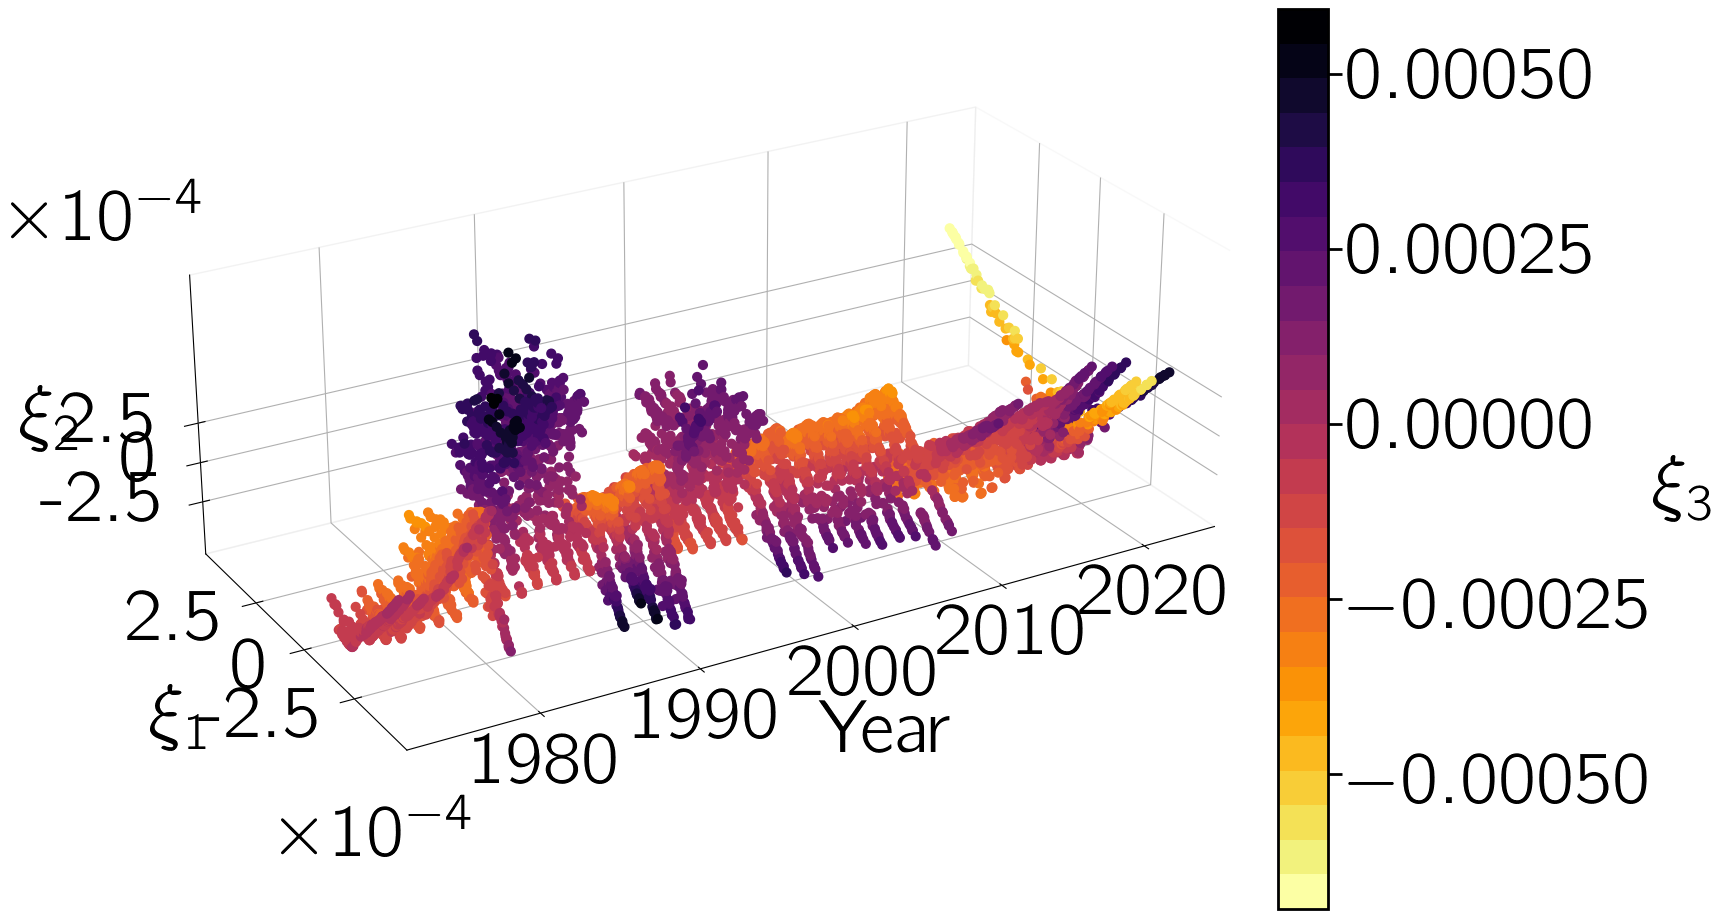

In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']


fontsize = 54

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig, axs = plt.subplots(1,1,sharex=True,figsize=(20,10))
#                         constrained_layout=True)
# ax1 = plt.subplot(4,2,1)
# ax2 = plt.subplot(4,2,2)
# ax3 = plt.subplot(4,2,3)
# ax4 = plt.subplot(4,2,4)
# ax5 = plt.subplot(1,2,2)


ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')





### AXIS 1, 3D MANIFOLDS
scale_x, scale_y, scale_z = 3, 1.5, 1
# ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax4), np.diag([scale_x, scale_y, scale_z, 1]))
ax1.set_box_aspect(aspect = (scale_x,scale_y,scale_z), zoom=1.35)
# ax1.auto_scale_xyz([0, len(dates)], [-0.0002,0.000125], [-0.0002,0.000175])
# ax1.pbaspect = [scale_x, scale_y, scale_z]
# ax1.dist = 5


# scale=np.diag([scale_x, scale_y, scale_z, 1.0])
# scale=scale*(1.0/scale.max())
# scale[3,3]=1.0

# def short_proj():
#     return np.dot(Axes3D.get_proj(ax1), scale)

# ax1.get_proj=short_proj

lw = 5

cmap = plt.get_cmap('inferno_r', 26)

# for i in range(0,len(dates)):
#     p=ax1.scatter(i,x1pma_no_amazon_edges[i,:,0],x1pma_no_amazon_edges[i,:,1],c=x1pma_no_amazon_edges[i,:,2],s=40,marker='o',
#                   cmap=cmap,alpha=1.0,clip_on=False,vmin=-0.0007, vmax=0.0007)

vmin = np.min(x1pma_no_amazon_edges[:,:,2])
vmax = np.max(x1pma_no_amazon_edges[:,:,2])

dim1_min = np.min(x1pma_no_amazon_edges[:,:,0])
dim1_max = np.max(x1pma_no_amazon_edges[:,:,0])
dim2_min = np.min(x1pma_no_amazon_edges[:,:,1])
dim2_max = np.max(x1pma_no_amazon_edges[:,:,1])

p=ax1.scatter(np.array([i for i in range(len(dates)) for _ in range(x1pma_no_amazon_edges[:,:,0].shape[1])]),
              np.ravel(x1pma_no_amazon_edges[:,:,0]),np.ravel(x1pma_no_amazon_edges[:,:,1]),c=np.ravel(x1pma_no_amazon_edges[:,:,2]),
              s=40,marker='o',cmap=cmap,alpha=1.0,clip_on=False,vmin=vmin, vmax=vmax,
              zorder=5)




#ax.set_yticklabels([1973,1983,1993,2003,2013])

# #ax.grid(False)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

labelpad = 40
ax1.set_xlabel(r'Year',fontsize=fontsize,labelpad=labelpad)

labelpad = 20
ax1.set_ylabel(r'$\xi_1$',fontsize=fontsize,labelpad=labelpad,va='bottom')
ax1.set_zlabel(r'$\xi_2$',fontsize=fontsize,labelpad=labelpad,va='center')

ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)

# ax1.text(13,-0.00065,0.0,"Year",fontsize=fontsize);
# ax1.text(-8,-0.00005,-0.00025,r'$\xi_1$',fontsize=fontsize);
# ax1.text(-9,-0.0,0.00006,r'$\xi_2$',fontsize=fontsize);

cax = fig.add_axes([.8, 0, .025, .9])

ticks = [-.0006, -.0003, 0, 0.0003, 0.0006]
cbar=plt.colorbar(p, cax=cax, orientation='vertical')
cbar.set_label(r'$\xi_3$',fontsize=fontsize,rotation=0,labelpad=20)

ax1.tick_params(length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=2)

cbar.ax.tick_params(length=10,width=2)
plt.setp(cbar.ax.spines.values(), linewidth=2)

# cbar.ax.set_yticklabels(ticks,fontsize=fontsize)






# ax1.set_ylim3d(-0.0002,0.000125)
# ax1.set_zlim3d(-0.0002,0.000175)
ax1.set_ylim3d(dim1_min,dim1_max)
ax1.set_zlim3d(dim2_min,dim2_max)
ax1.set_xlim3d(0,len(dates))

# ax1.view_init(25, 260)
ax1.view_init(25, 240)


ticks = [7, 17, 27, 37, 47]
ax1.set_xticks(ticks)
ax1.set_xticklabels([dates[i][5:] for i in ticks])
# ax1.set_xticks([2,17,32,47])
# ax1.set_xticklabels([1975,1990,2005,2020],fontsize=fontsize)


ticks = [-.00025, 0, .00025]
ax1.set_yticks(ticks)
ax1.set_yticklabels(['-2.5', '0', '2.5'], va='center', ha='right')
# ax1.set_yticklabels(["{:.1e}".format(tick) for tick in ticks])

ticks = [-.00025, 0, .00025]
ax1.set_zticks(ticks)
ax1.set_zticklabels(['-2.5', '0', '2.5'], va='center', ha='right')
# ax1.set_zticklabels(["{:.1e}".format(tick) for tick in ticks])

ax1.annotate(r'$\times 10^{-4}$', xy=(-.4, .8), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')
ax1.annotate(r'$\times 10^{-4}$', xy=(-.05, 0), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')

# ax1.set_yticks([-0.0001,0.0001])
# ax1.set_yticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.set_zticks([-0.0001,0.0001])
# ax1.set_zticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.dist = 5



# fig.tight_layout()

title = 'Manifold (No Amazon Edges)'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

In [ ]:
for i in range(len(dates)):
  x1, x2, x3, x4 = x2pma[i]
  print(len(x1),len(x2),len(x3),len(x4))

2990 2990 2990 2990
2776 2776 2776 2776
2884 2884 2884 2884
2819 2819 2819 2819
2752 2752 2752 2752
2673 2673 2673 2673
2604 2604 2604 2604
2496 2496 2496 2496
2455 2455 2455 2455
2360 2360 2360 2360
2311 2311 2311 2311
2286 2286 2286 2286
2248 2248 2248 2248
2242 2242 2242 2242
2237 2237 2237 2237
2262 2262 2262 2262
2301 2301 2301 2301
2303 2303 2303 2303
2190 2190 2190 2190
2178 2178 2178 2178
2115 2115 2115 2115
2114 2114 2114 2114
2085 2085 2085 2085
2097 2097 2097 2097
2114 2114 2114 2114
2219 2219 2219 2219
2230 2230 2230 2230
2289 2289 2289 2289
2368 2368 2368 2368
2408 2408 2408 2408
2417 2417 2417 2417
2503 2503 2503 2503
2604 2604 2604 2604
2636 2636 2636 2636
2693 2693 2693 2693
2678 2678 2678 2678
2656 2656 2656 2656
2718 2718 2718 2718
2815 2815 2815 2815
2789 2789 2789 2789
2777 2777 2777 2777
2747 2747 2747 2747
2781 2781 2781 2781
2883 2883 2883 2883
3027 3027 3027 3027
3093 3093 3093 3093
3063 3063 3063 3063
3092 3092 3092 3092
3108 3108 3108 3108
3130 3130 3130 3130


In [ ]:
print(np.min([np.min(x2pma[i][2]) for i in range(len(dates))]))

-0.0021811233075344754


In [ ]:
print(np.max([np.max(x2pma[i][2]) for i in range(len(dates))]))

0.0022249477401027743


In [ ]:
i_min = 0
for i in range(len(dates)):
  if np.min(x1pma_no_amazon_edges[i,:,2]) < np.min(x1pma_no_amazon_edges[i_min,:,2]):
    i_min = i
print(i_min)

50


In [ ]:
print(np.min(x1pma_no_amazon_edges[i_min,:,2]))

-0.0012121467232907239


<ipython-input-7-8c4b722f227c>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')


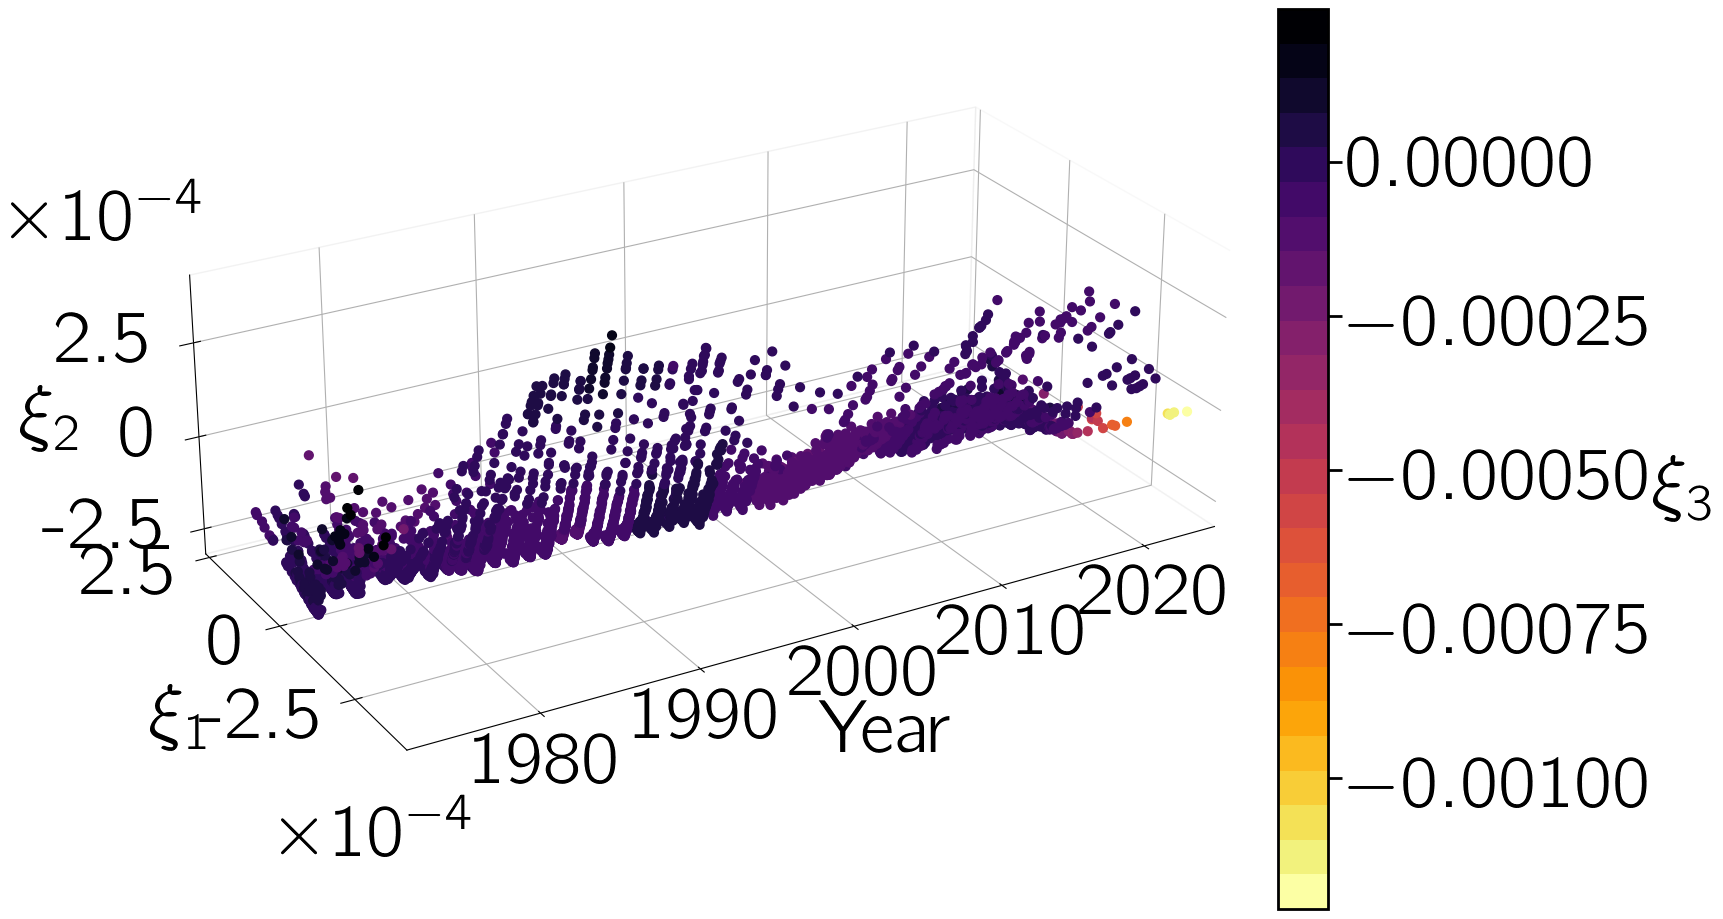

In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']


fontsize = 54

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig, axs = plt.subplots(1,1,sharex=True,figsize=(20,10))
#                         constrained_layout=True)
# ax1 = plt.subplot(4,2,1)
# ax2 = plt.subplot(4,2,2)
# ax3 = plt.subplot(4,2,3)
# ax4 = plt.subplot(4,2,4)
# ax5 = plt.subplot(1,2,2)


ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')





### AXIS 1, 3D MANIFOLDS
scale_x, scale_y, scale_z = 3, 1.5, 1
# ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax4), np.diag([scale_x, scale_y, scale_z, 1]))
ax1.set_box_aspect(aspect = (scale_x,scale_y,scale_z), zoom=1.35)
# ax1.auto_scale_xyz([0, len(dates)], [-0.0002,0.000125], [-0.0002,0.000175])
# ax1.pbaspect = [scale_x, scale_y, scale_z]
# ax1.dist = 5


# scale=np.diag([scale_x, scale_y, scale_z, 1.0])
# scale=scale*(1.0/scale.max())
# scale[3,3]=1.0

# def short_proj():
#     return np.dot(Axes3D.get_proj(ax1), scale)

# ax1.get_proj=short_proj

lw = 5

cmap = plt.get_cmap('inferno_r', 26)

# for i in range(0,len(dates)):
#     p=ax1.scatter(i,x1pma_no_amazon_edges[i,:,0],x1pma_no_amazon_edges[i,:,1],c=x1pma_no_amazon_edges[i,:,2],s=40,marker='o',
#                   cmap=cmap,alpha=1.0,clip_on=False,vmin=-0.0007, vmax=0.0007)

vmin = np.min(x1pma_no_amazon_edges[:,:,2])
vmax = np.max(x1pma_no_amazon_edges[:,:,2])

dim1_min = np.min(x1pma_no_amazon_edges[:,:,0])
dim1_max = np.max(x1pma_no_amazon_edges[:,:,0])
dim2_min = np.min(x1pma_no_amazon_edges[:,:,1])
dim2_max = np.max(x1pma_no_amazon_edges[:,:,1])

p=ax1.scatter(np.array([i for i in range(len(dates)) for _ in range(x1pma_no_amazon_edges[:,:,0].shape[1])]),
              np.ravel(x1pma_no_amazon_edges[:,:,0]),np.ravel(x1pma_no_amazon_edges[:,:,1]),c=np.ravel(x1pma_no_amazon_edges[:,:,2]),
              s=40,marker='o',cmap=cmap,alpha=1.0,clip_on=False,vmin=vmin, vmax=vmax,
              zorder=5)




#ax.set_yticklabels([1973,1983,1993,2003,2013])

# #ax.grid(False)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

labelpad = 40
ax1.set_xlabel(r'Year',fontsize=fontsize,labelpad=labelpad)

labelpad = 20
ax1.set_ylabel(r'$\xi_1$',fontsize=fontsize,labelpad=labelpad,va='bottom')
ax1.set_zlabel(r'$\xi_2$',fontsize=fontsize,labelpad=labelpad,va='center')

ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)

# ax1.text(13,-0.00065,0.0,"Year",fontsize=fontsize);
# ax1.text(-8,-0.00005,-0.00025,r'$\xi_1$',fontsize=fontsize);
# ax1.text(-9,-0.0,0.00006,r'$\xi_2$',fontsize=fontsize);

cax = fig.add_axes([.8, 0, .025, .9])

ticks = [-.0006, -.0003, 0, 0.0003, 0.0006]
cbar=plt.colorbar(p, cax=cax, orientation='vertical')
cbar.set_label(r'$\xi_3$',fontsize=fontsize,rotation=0,labelpad=20)

ax1.tick_params(length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=2)

cbar.ax.tick_params(length=10,width=2)
plt.setp(cbar.ax.spines.values(), linewidth=2)

# cbar.ax.set_yticklabels(ticks,fontsize=fontsize)






# ax1.set_ylim3d(-0.0002,0.000125)
# ax1.set_zlim3d(-0.0002,0.000175)
ax1.set_ylim3d(dim1_min,dim1_max)
ax1.set_zlim3d(dim2_min,dim2_max)
ax1.set_xlim3d(0,len(dates))

# ax1.view_init(25, 260)
ax1.view_init(25, 240)


ticks = [7, 17, 27, 37, 47]
ax1.set_xticks(ticks)
ax1.set_xticklabels([dates[i][5:] for i in ticks])
# ax1.set_xticks([2,17,32,47])
# ax1.set_xticklabels([1975,1990,2005,2020],fontsize=fontsize)


ticks = [-.00025, 0, .00025]
ax1.set_yticks(ticks)
ax1.set_yticklabels(['-2.5', '0', '2.5'], va='center', ha='right')
# ax1.set_yticklabels(["{:.1e}".format(tick) for tick in ticks])

ticks = [-.00025, 0, .00025]
ax1.set_zticks(ticks)
ax1.set_zticklabels(['-2.5', '0', '2.5'], va='center', ha='right')
# ax1.set_zticklabels(["{:.1e}".format(tick) for tick in ticks])

ax1.annotate(r'$\times 10^{-4}$', xy=(-.4, .8), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')
ax1.annotate(r'$\times 10^{-4}$', xy=(-.05, 0), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')

# ax1.set_yticks([-0.0001,0.0001])
# ax1.set_yticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.set_zticks([-0.0001,0.0001])
# ax1.set_zticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.dist = 5



# fig.tight_layout()

title = 'Manifold (No Amazon Edges)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

<ipython-input-27-2c77c9a54ecf>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')
<ipython-input-27-2c77c9a54ecf>:148: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 5
<ipython-input-27-2c77c9a54ecf>:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-27-2c77c9a54ecf>:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


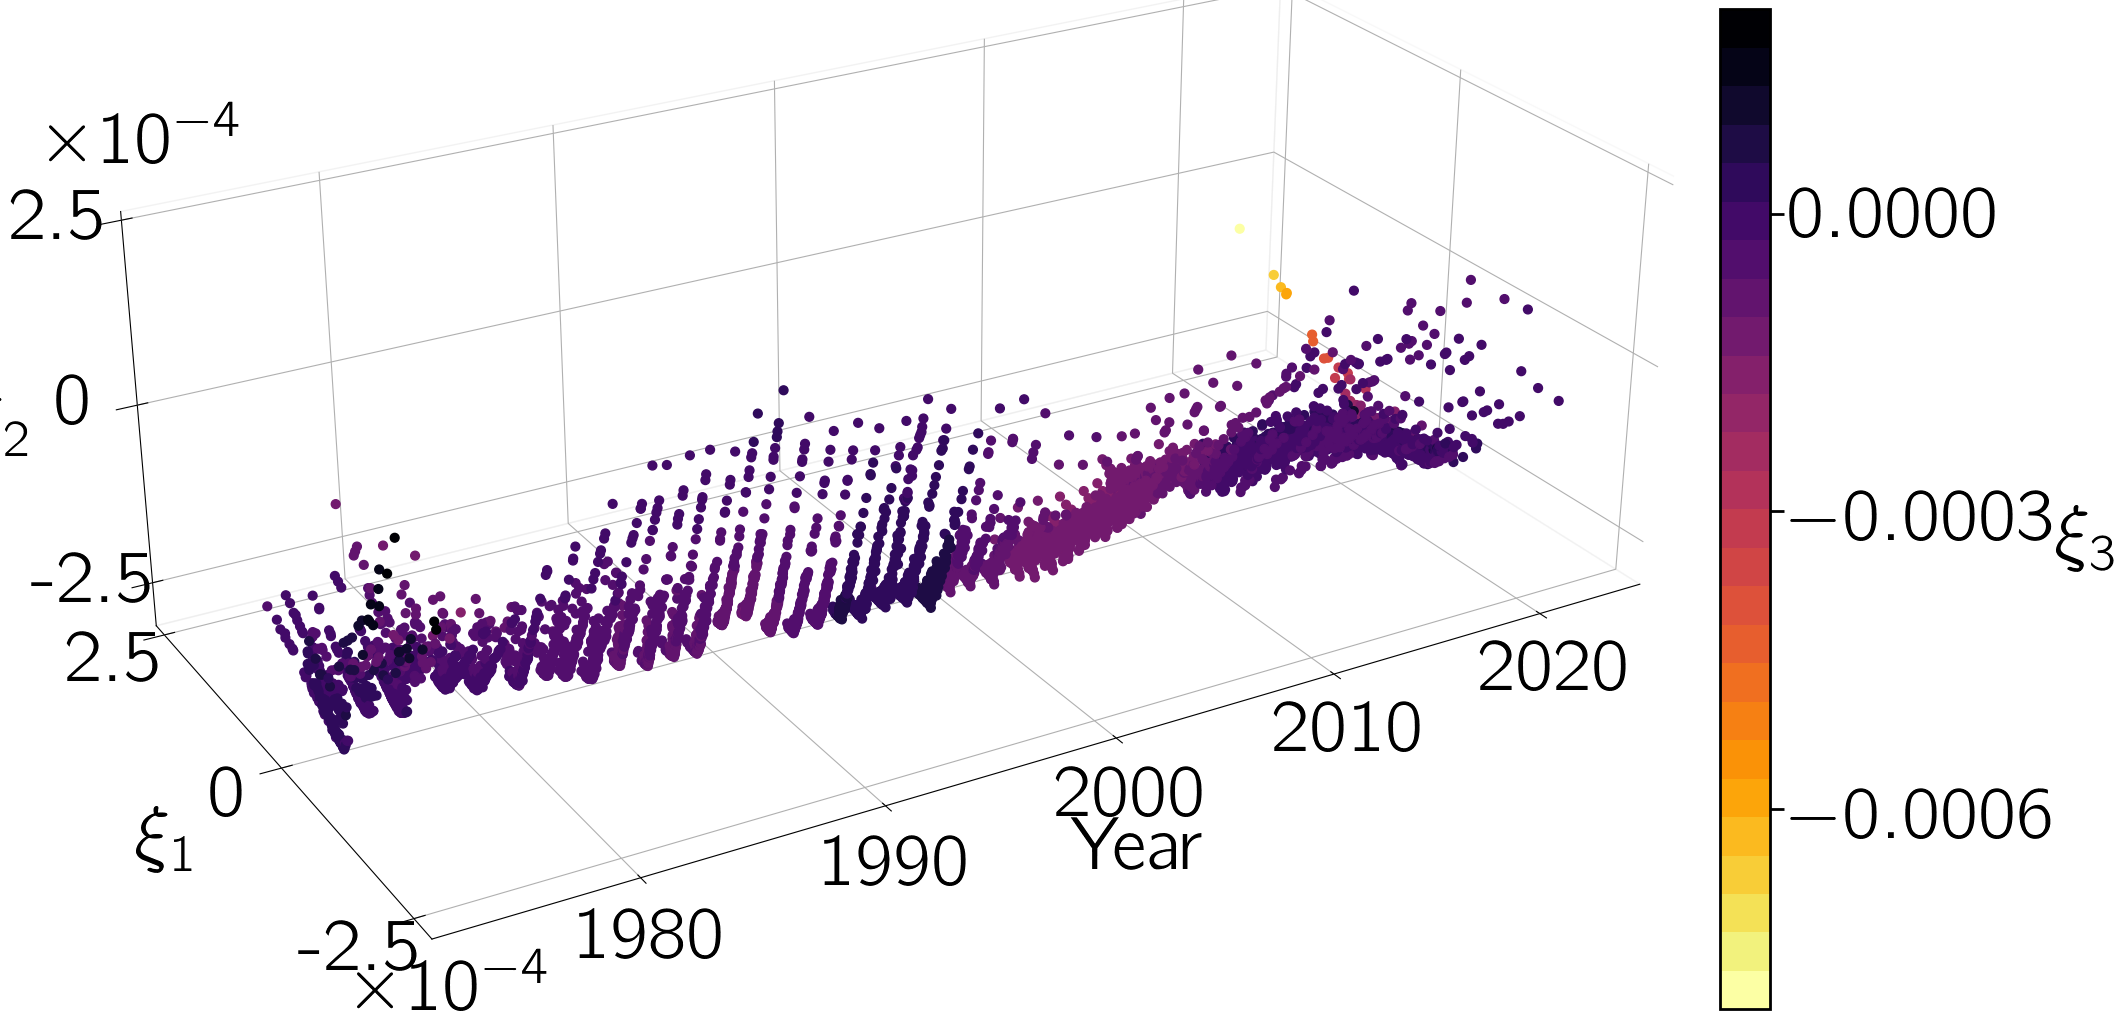

In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']


fontsize = 54

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig, axs = plt.subplots(1,1,sharex=True,figsize=(20,10))
#                         constrained_layout=True)
# ax1 = plt.subplot(4,2,1)
# ax2 = plt.subplot(4,2,2)
# ax3 = plt.subplot(4,2,3)
# ax4 = plt.subplot(4,2,4)
# ax5 = plt.subplot(1,2,2)


ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')





### AXIS 1, 3D MANIFOLDS
scale_x, scale_y, scale_z = 3, 1.5, 1
# ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax4), np.diag([scale_x, scale_y, scale_z, 1]))
ax1.set_box_aspect(aspect = (scale_x,scale_y,scale_z), zoom=1)
# ax1.auto_scale_xyz([0, len(dates)], [-0.0002,0.000125], [-0.0002,0.000175])
# ax1.pbaspect = [scale_x, scale_y, scale_z]
# ax1.dist = 5


# scale=np.diag([scale_x, scale_y, scale_z, 1.0])
# scale=scale*(1.0/scale.max())
# scale[3,3]=1.0

# def short_proj():
#     return np.dot(Axes3D.get_proj(ax1), scale)

# ax1.get_proj=short_proj

lw = 5

cmap = plt.get_cmap('inferno_r', 26)

# for i in range(0,len(dates)):
#     p=ax1.scatter(i,x1pma[i,:,0],x1pma[i,:,1],c=x1pma[i,:,2],s=40,marker='o',
#                   cmap=cmap,alpha=1.0,clip_on=False,vmin=-0.0007, vmax=0.0007)

vmin = np.min(x1pma[:,:,2])
vmax = np.max(x1pma[:,:,2])

dim1_min = np.min(x1pma[:,:,0])
dim1_max = np.max(x1pma[:,:,0])
dim2_min = np.min(x1pma[:,:,1])
dim2_max = np.max(x1pma[:,:,1])

p=ax1.scatter(np.array([i for i in range(len(dates)) for _ in range(x1pma[:,:,0].shape[1])]),
              np.ravel(x1pma[:,:,0]),np.ravel(x1pma[:,:,1]),c=np.ravel(x1pma[:,:,2]),
              s=40,marker='o',cmap=cmap,alpha=1.0,clip_on=False,vmin=vmin, vmax=vmax,
              zorder=5)




#ax.set_yticklabels([1973,1983,1993,2003,2013])

# #ax.grid(False)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

labelpad = 20
ax1.set_xlabel(r'Year',fontsize=fontsize,labelpad=labelpad)

labelpad = 5
ax1.set_ylabel(r'$\xi_1$',fontsize=fontsize,labelpad=labelpad)
ax1.set_zlabel(r'$\xi_2$',fontsize=fontsize,labelpad=labelpad)

ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)

# ax1.text(13,-0.00065,0.0,"Year",fontsize=fontsize);
# ax1.text(-8,-0.00005,-0.00025,r'$\xi_1$',fontsize=fontsize);
# ax1.text(-9,-0.0,0.00006,r'$\xi_2$',fontsize=fontsize);

cax = fig.add_axes([.925, -.1, .025, 1])

ticks = [-.0006, -.0003, 0, 0.0003, 0.0006]
cbar=plt.colorbar(p, cax=cax, ticks=ticks, orientation='vertical')
cbar.set_label(r'$\xi_3$',fontsize=fontsize,rotation=0,labelpad=20)

ax1.tick_params(length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=2)

cbar.ax.tick_params(length=10,width=2)
plt.setp(cbar.ax.spines.values(), linewidth=2)

# cbar.ax.set_yticklabels(ticks,fontsize=fontsize)






# ax1.set_ylim3d(-0.0002,0.000125)
# ax1.set_zlim3d(-0.0002,0.000175)
ax1.set_ylim3d(dim1_min,dim1_max)
ax1.set_zlim3d(dim2_min,dim2_max)
ax1.set_xlim3d(0,len(dates))

# ax1.view_init(25, 260)
ax1.view_init(25, 240)


ticks = [7, 17, 27, 37, 47]
ax1.set_xticks(ticks)
ax1.set_xticklabels([dates[i][5:] for i in ticks])
# ax1.set_xticks([2,17,32,47])
# ax1.set_xticklabels([1975,1990,2005,2020],fontsize=fontsize)


ticks = [-.00025, 0, .00025]
ax1.set_yticks(ticks)
ax1.set_yticklabels(['-2.5', '0', '2.5'], va='center')
# ax1.set_yticklabels(["{:.1e}".format(tick) for tick in ticks])

ticks = [-.00025, 0, .00025]
ax1.set_zticks(ticks)
ax1.set_zticklabels(['-2.5', '0', '2.5'], va='center')
# ax1.set_zticklabels(["{:.1e}".format(tick) for tick in ticks])

ax1.annotate(r'$\times 10^{-4}$', xy=(-.6, .9), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')
ax1.annotate(r'$\times 10^{-4}$', xy=(-.2, -.2), xycoords="axes fraction",
             fontsize=fontsize, usetex=True, va='top', ha='left')

# ax1.set_yticks([-0.0001,0.0001])
# ax1.set_yticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.set_zticks([-0.0001,0.0001])
# ax1.set_zticklabels([-0.0001,0.0001],fontsize=fontsize)

ax1.dist = 5



fig.tight_layout()

title = 'Manifold'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

<ipython-input-62-67981bdeea74>:157: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 5
<ipython-input-62-67981bdeea74>:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-62-67981bdeea74>:161: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


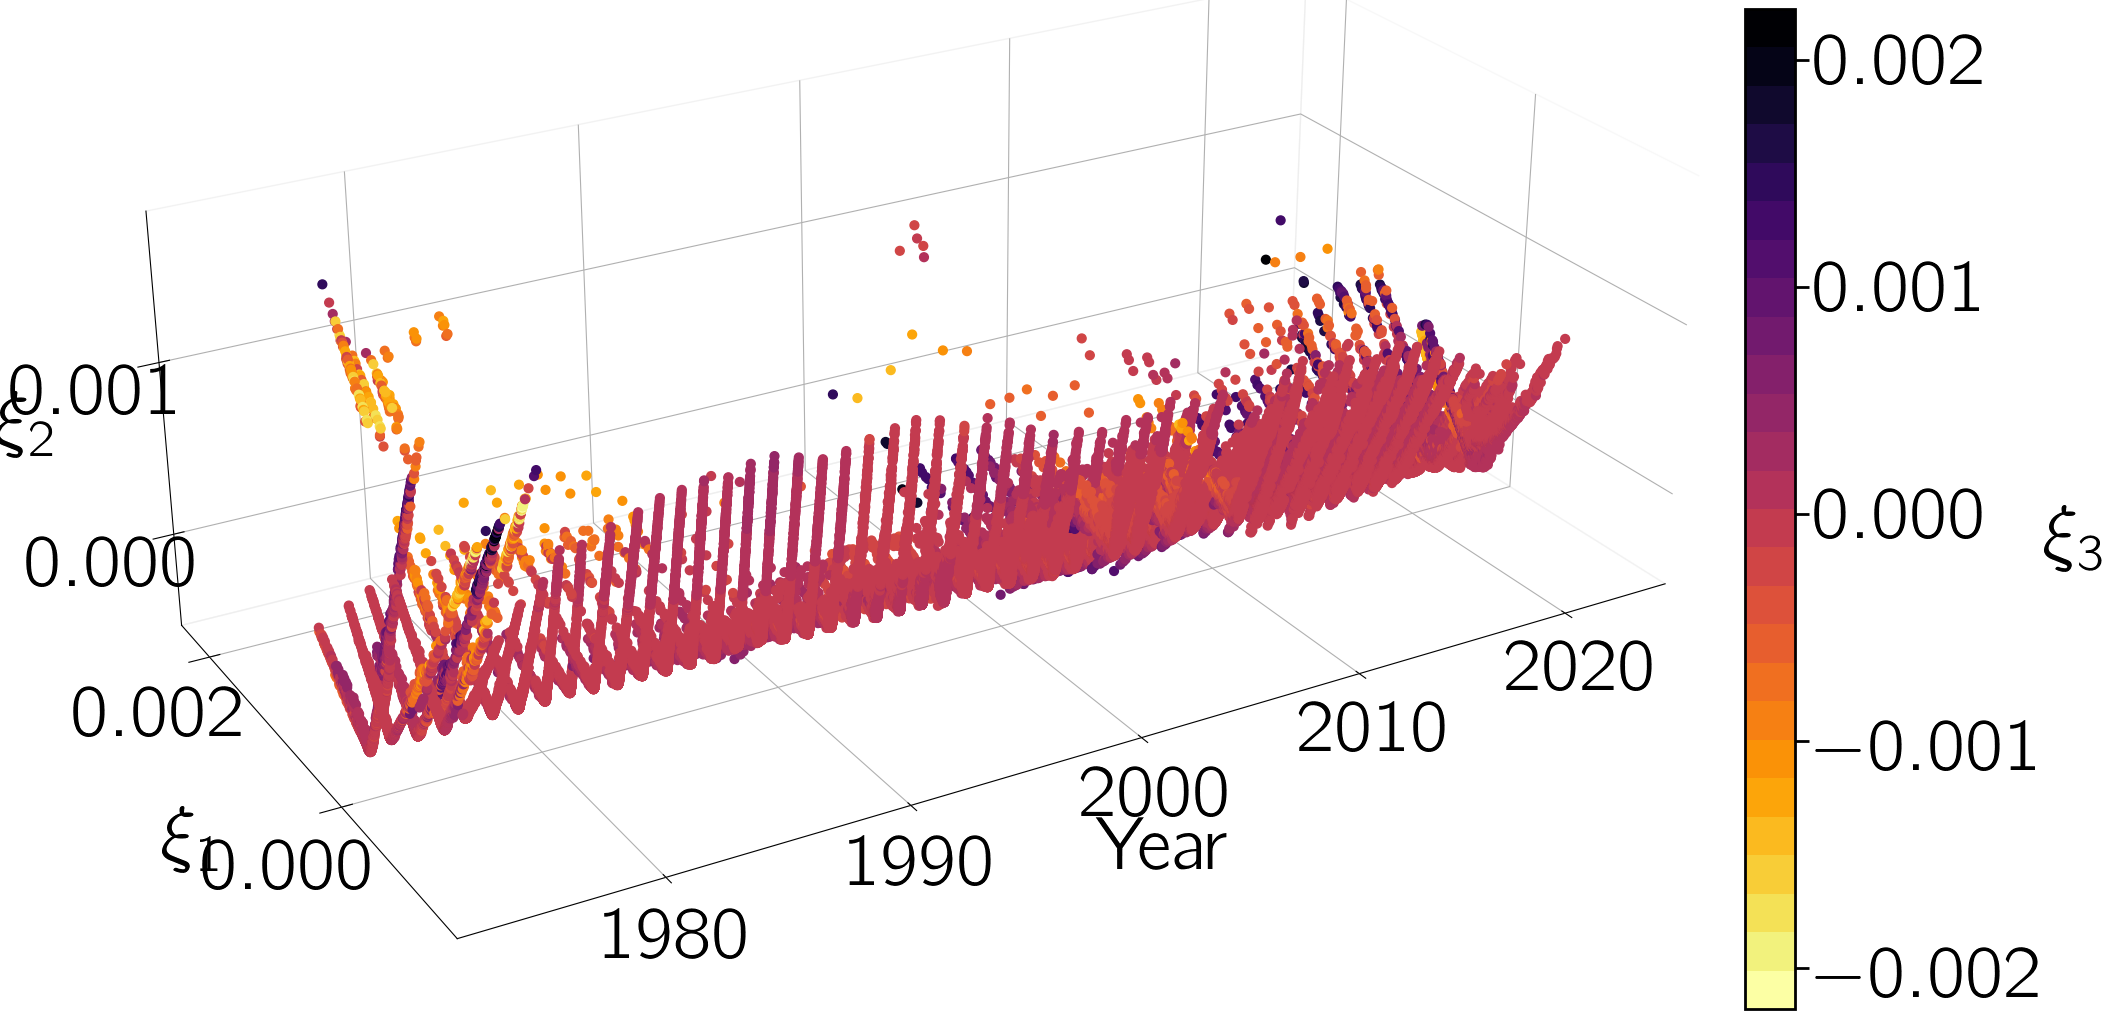

In [ ]:
# mpl.rcParams['text.latex.preamble'] = [
#     r'\usepackage[dvipsnames]{xcolor}']


fontsize = 54

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig = plt.figure(figsize=(20,10))
#                         constrained_layout=True)
# ax1 = plt.subplot(4,2,1)
# ax2 = plt.subplot(4,2,2)
# ax3 = plt.subplot(4,2,3)
# ax4 = plt.subplot(4,2,4)
# ax5 = plt.subplot(1,2,2)


ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=2, projection='3d')





### AXIS 1, 3D MANIFOLDS
scale_x, scale_y, scale_z = 3, 1.5, 1
# ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax4), np.diag([scale_x, scale_y, scale_z, 1]))
ax1.set_box_aspect(aspect = (scale_x,scale_y,scale_z), zoom=1)
# ax1.auto_scale_xyz([0, len(dates)], [-0.0002,0.000125], [-0.0002,0.000175])
# ax1.pbaspect = [scale_x, scale_y, scale_z]
# ax1.dist = 5


# scale=np.diag([scale_x, scale_y, scale_z, 1.0])
# scale=scale*(1.0/scale.max())
# scale[3,3]=1.0

# def short_proj():
#     return np.dot(Axes3D.get_proj(ax1), scale)

# ax1.get_proj=short_proj

lw = 5

cmap = plt.get_cmap('inferno_r', 26)

# for i in range(0,len(dates)):
#     p=ax1.scatter(i,x2pma[i,:,0],x2pma[i,:,1],c=x2pma[i,:,2],s=40,marker='o',
#                   cmap=cmap,alpha=1.0,clip_on=False,vmin=-0.0007, vmax=0.0007)

# vmin = np.min(x2pma[:,:,2])
# vmax = np.max(x2pma[:,:,2])

dim1_min = np.min([np.min(x2pma[i][0]) for i in range(len(dates))])
dim1_max = np.max([np.max(x2pma[i][0]) for i in range(len(dates))])
dim2_min = np.min([np.min(x2pma[i][1]) for i in range(len(dates))])
dim2_max = np.max([np.max(x2pma[i][1]) for i in range(len(dates))])

vmin = np.min([np.min(x2pma[i][2]) for i in range(len(dates))])
vmax = np.max([np.max(x2pma[i][2]) for i in range(len(dates))])

for i in range(len(dates)):
  p = ax1.scatter(i,
              np.ravel(x2pma[i][0]),np.ravel(x2pma[i][1]),c=np.ravel(x2pma[i][2]),
              s=40,marker='o',cmap=cmap,alpha=1.0,clip_on=False,vmin=vmin, vmax=vmax,
              zorder=5)

# p=ax1.scatter(np.array([i for i in range(len(dates)) for _ in range(x2pma[:,:,0].shape[1])]),
#               np.ravel(x2pma[:,:,0]),np.ravel(x2pma[:,:,1]),c=np.ravel(x2pma[:,:,2]),
#               s=40,marker='o',cmap=cmap,alpha=1.0,clip_on=False,vmin=vmin, vmax=vmax,
#               zorder=5)




#ax.set_yticklabels([1973,1983,1993,2003,2013])

# #ax.grid(False)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

labelpad = 20
ax1.set_xlabel(r'Year',fontsize=fontsize,labelpad=labelpad)

labelpad = 5
ax1.set_ylabel(r'$\xi_1$',fontsize=fontsize,labelpad=labelpad)
ax1.set_zlabel(r'$\xi_2$',fontsize=fontsize,labelpad=labelpad)

ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)

# ax1.text(13,-0.00065,0.0,"Year",fontsize=fontsize);
# ax1.text(-8,-0.00005,-0.00025,r'$\xi_1$',fontsize=fontsize);
# ax1.text(-9,-0.0,0.00006,r'$\xi_2$',fontsize=fontsize);

cax = fig.add_axes([.925, -.1, .025, 1])

# ticks = [-.0006, -.0003, 0, 0.0003, 0.0006]
cbar=plt.colorbar(p, cax=cax, orientation='vertical')
cbar.set_label(r'$\xi_3$',fontsize=fontsize,rotation=0,labelpad=20)

ax1.tick_params(length=10,width=2)
plt.setp(ax1.spines.values(), linewidth=2)

cbar.ax.tick_params(length=10,width=2)
plt.setp(cbar.ax.spines.values(), linewidth=2)

# cbar.ax.set_yticklabels(ticks,fontsize=fontsize)






# ax1.set_ylim3d(-0.0002,0.000125)
# ax1.set_zlim3d(-0.0002,0.000175)
ax1.set_ylim3d(dim1_min,dim1_max)
ax1.set_zlim3d(dim2_min,dim2_max)
ax1.set_xlim3d(0,len(dates))

# ax1.view_init(25, 260)
ax1.view_init(25, 240)


ticks = [7, 17, 27, 37, 47]
ax1.set_xticks(ticks)
ax1.set_xticklabels([dates[i][5:] for i in ticks])
# ax1.set_xticks([2,17,32,47])
# ax1.set_xticklabels([1975,1990,2005,2020],fontsize=fontsize)


# ticks = [-.00025, 0, .00025]
# ax1.set_yticks(ticks)
# ax1.set_yticklabels(['-2.5', '0', '2.5'], va='center')
# # ax1.set_yticklabels(["{:.1e}".format(tick) for tick in ticks])

# ticks = [-.00025, 0, .00025]
# ax1.set_zticks(ticks)
# ax1.set_zticklabels(['-2.5', '0', '2.5'], va='center')
# # ax1.set_zticklabels(["{:.1e}".format(tick) for tick in ticks])

# ax1.annotate(r'$\times 10^{-4}$', xy=(-.6, .9), xycoords="axes fraction",
#              fontsize=fontsize, usetex=True, va='top', ha='left')
# ax1.annotate(r'$\times 10^{-4}$', xy=(-.2, -.2), xycoords="axes fraction",
#              fontsize=fontsize, usetex=True, va='top', ha='left')

# ax1.set_yticks([-0.0001,0.0001])
# ax1.set_yticklabels([-0.0001,0.0001],fontsize=fontsize)

# ax1.set_zticks([-0.0001,0.0001])
# ax1.set_zticklabels([-0.0001,0.0001],fontsize=fontsize)

ax1.dist = 5



fig.tight_layout()

title = 'Manifold (Neighbors)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

<ipython-input-26-9413f30571b1>:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1=plt.subplot(30,5,i-j)


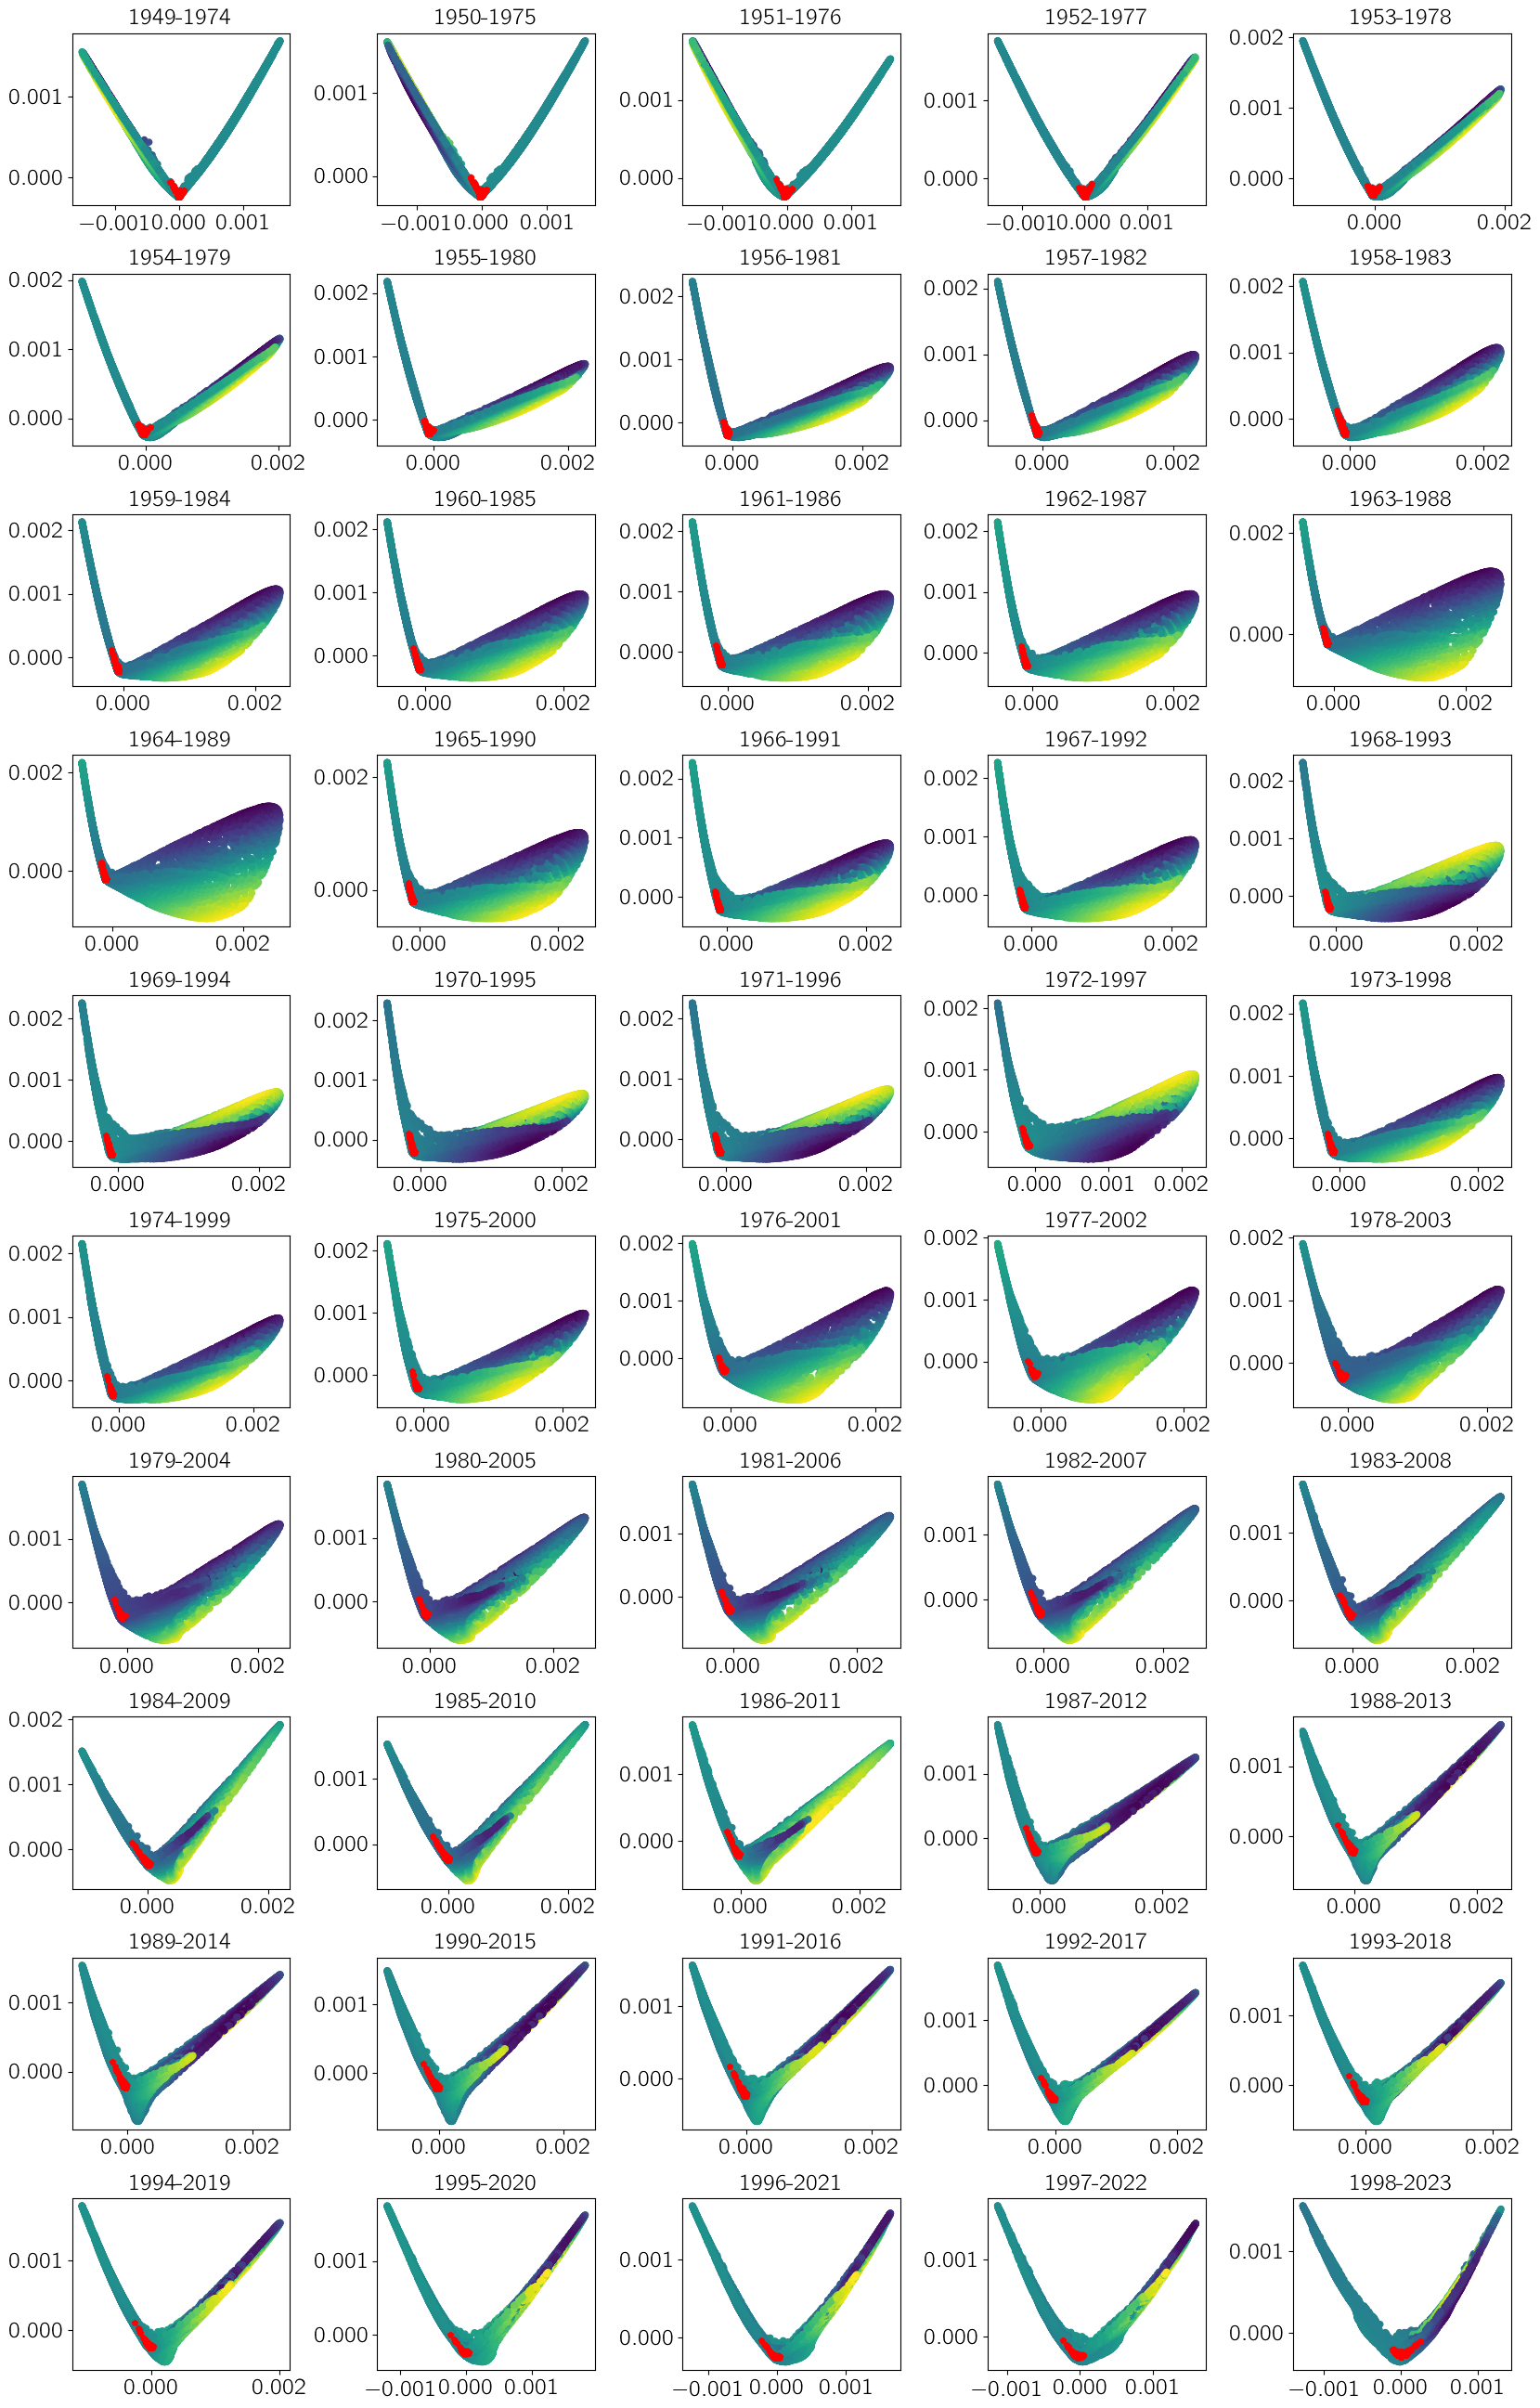

In [ ]:
fontsize = 18

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)


fig = plt.figure(figsize=(20, 100))
#ax1 = plt.axes(xlim=(-.00035,.00055), ylim=(-.00035,.00055))
#line, = ax1.plot([],[])
plt.title(dates[0], loc='center', fontsize=18)
plt.xlabel('$x$',fontsize=18)
plt.ylabel('$y$',fontsize=18)

#ax1=plt.subplot(5,5,1)
#line1 = ax1.plot(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],'o',color='blue',label='Non-Amazon Nodes')[0]
#line2 = ax1.plot(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')[0]
#line1 = ax1.scatter(manifold_full_rank_dict[dates[0]][:,0],manifold_full_rank_dict[dates[0]][:,1],
#                    s=20,marker='o',label='Non-Amazon Nodes')
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                    s=20,marker='p',label='Amazon Nodes')

#plt.title(dates[i], loc='center', fontsize=18)
#line2 = ax1.scatter(manifold_full_rank_dict[dates[0]][amazon_nodes,0],manifold_full_rank_dict[dates[0]][amazon_nodes,1],
#                 'o',color='orange',label='Amazon Nodes')


#plt.legend(loc='upper right',prop={'size': 15})

def update(i,j):
    ax1=plt.subplot(30,5,i-j)

    line1 = ax1.scatter(manifold_dict[dates[i]][:,0],manifold_dict[dates[i]][:,1],
                    s=20,c=manifold_dict[dates[i]][:,2],marker='o',label='Non-Amazon Nodes')
    line2 = ax1.scatter(manifold_dict[dates[i]][amazon_nodes,0],
                        manifold_dict[dates[i]][amazon_nodes,1],
                    s=20,c='red',marker='p',label='Amazon Nodes')

    plt.title(dates[i], loc='center', fontsize=18)
#

#def update(i):
#    line1.set_data(manifold_full_rank_dict[dates[i]][:,0],manifold_full_rank_dict[dates[i]][:,1])
#    line2.set_data(manifold_full_rank_dict[dates[i]][amazon_nodes,0],manifold_full_rank_dict[dates[i]][amazon_nodes,1])
#    plt.title(dates[i], loc='center', fontsize=18)
#    return line1,line2,ax1

for i in range(1,len(dates)):
    update(i,0)


plt.subplots_adjust(wspace=0.4,hspace=0.4)

#ani = animation.FuncAnimation(fig, update, frames=len(dates))
#writer = animation.PillowWriter(fps=2)
#ani.save(fig_dir+'Manifolds_Full_Rank.gif', writer=writer, dpi=200)
#plt.close(fig)

title = 'Manifolds'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)


In [ ]:
print(np.max(x1pma[:,:,2]))

0.00020569628092351956
